# To Do For Today
* X clean code
* X remove URLs
* X remove usernames
* X time of day distributions
* X get stock info
* X add impeachment column
* X rerun polarity after cleaning
* X new sentiment analysis
* X retweets vs originals significance test
* X clean text encoding (&amp;)
* X rolling averages
* X do positive or negative tweets/retweets get more likes/retweets
* add function that allows you to compare average inside and outside two dates
* do something with tweetstorms
* find rolling average of tweets (not time)
* compare to Obama
* filters: inaug scandal, covid, impeachment, russia invest, midterms, Obamacare repeal, Stormy Daniels
* identify time of peaks/valleys
* X clean code
* add time period functionality to DJIA and sentiment
* find way to trace dates in graphs
* redo all graphs with original tweets only
* X get rid of colummns
* X histograms/graphs with Vader
* examples of pos/neg tweets
* X does he tweet more when the market is down?
* X period with no retweets
* X add tweets per day column
* REMOVE HASHTAGS
* K NEAREST NEIGHBORS
* add markup
* clean up
* ask what is needed to publish

# Trump Tweets
This project was inspired by listening to political podcasts during the COVID-19 pandemic while taking my first data science courses. I repeatedly heard pundits on these podcasts assert that the only thing Donald Trump cares about is the stock market. I heard the line repeated so frequently that I wondered if data science could be used to test the assertion. This project was born out of that question.

The basic concept was to perform sentiment analysis on all of Trump's tweets since assuming office and to compare the sentiment of his tweets to stock market performance. Because this was my first unguided data science project and because I'm interested in politics, there are also a number of exploratory diversions. I found the mildly interesting and hope that you will as well.

In [498]:
import pandas as pd
import matplotlib.pyplot as plt

tweets=pd.read_csv('tweets.csv')

In [499]:
tweets['text'] = tweets['text'].str.replace('&amp;', '&')
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets['is_retweet']=tweets['is_retweet'].astype(bool)
tweets['hour'] = tweets['created_at'].dt.hour

In [500]:
tweets['clean_text'] = tweets['text'].str.replace(r'@([^\s]+)','')
tweets['clean_text'] = tweets['clean_text'].str.replace(r'(https?)://([^\s]+)','')

In [501]:
from textblob import TextBlob

def get_pol_subj(row):
    #print(row['text'])
    text = TextBlob(row['clean_text'])
    row['polarity'] = text.sentiment[0]
    row['subjectivity'] = text.sentiment[1]
    
    return row
    
tweets = tweets.apply(get_pol_subj, axis=1)

In [ ]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()

def vader(row):
    pol = sia.polarity_scores(row['clean_text'])
    #row['vader'] = pol
    row['vader_neg']= pol['neg']
    row['vader_neu']= pol['neu']
    row['vader_pos']= pol['pos']
    row['vader_compound'] = pol['compound']

    return row     

tweets = tweets.apply(vader, axis=1)

In [ ]:
import numpy as np

def rolling(row,days,cols):
    end_date = row['created_at']
    start_date = row['created_at']-datetime.timedelta(days=days)
    
    tweets_mask= (tweets['created_at']>=start_date) & (tweets['created_at']<=end_date)
    
    for col in cols:
        new_col_name = col+'_'+str(days)+'_days_rolling'
        row[new_col_name] =np.mean(tweets.loc[tweets_mask,col])
        
    return row

cols = ['polarity', 'vader_compound']
days = [0,15,30,45,60]
for day in days:    
    tweets = tweets.apply(rolling, axis=1,args=(day,cols))

In [ ]:
djia = pd.read_csv('djia.csv')

djia['Date'] = pd.to_datetime(djia['Date'])

djia['Week Change']=djia['Close'].pct_change(periods=5)
djia['Two Week Change']=djia['Close'].pct_change(periods=10)
djia['Three Week Change']=djia['Close'].pct_change(periods=15)
djia['One Month Change']=djia['Close'].pct_change(periods=20)
djia['Daily_Percent_Inc']=100*((djia['Close']/djia['Open'])-1)

def get_djia_info(row):
    date = row['created_at'].date()
    
    djia_date = djia['Date'].dt.date
    
    mask = (djia_date == date)
    
    while mask.sum() != 1:
        date = date - datetime.timedelta(days=1)
        mask = (djia_date == date)
        
    row['djia'] = djia[mask]['Close'].sum()
    row['djia_1_day'] = djia[mask]['Daily_Percent_Inc'].sum()
    row['djia_1_week'] = djia[mask]['Week Change'].sum()
    row['djia_2_week'] = djia[mask]['Two Week Change'].sum()
    row['djia_3_week'] = djia[mask]['Three Week Change'].sum()
    row['djia_4_week'] = djia[mask]['One Month Change'].sum()
    
    return row

tweets = tweets.apply(get_djia_info, axis=1)

In [660]:
def tweets_per_day(row):
    date = row['created_at'].date()
    
    mask = tweets['created_at'].dt.date == date
    
    row['daily_tweet_count']=mask.sum()
    return row

tweets = tweets.apply(tweets_per_day, axis=1)

In [736]:
tweets['date'] = tweets['created_at'].dt.date
tweets.head()

source                                               text  \
0  Twitter for iPhone  .....are therefore given massive advantages ov...   
1  Twitter for iPhone  Why is it that China for decades and with a po...   
2  Twitter for iPhone         Doing a GREAT job! https://t.co/OYRpiYiXpp   
3  Twitter for iPhone                 Thank you! https://t.co/oARCqHpblU   
4  Twitter for iPhone  RT @madisongesiotto: Unreal! (But not surprising)   

           created_at  retweet_count  favorite_count  is_retweet  \
0 2020-05-16 22:58:23           4081           16941       False   
1 2020-05-16 22:58:20           5709           20677       False   
2 2020-05-16 22:33:18           8654           35536       False   
3 2020-05-16 22:32:07           3327           12947       False   
4 2020-05-16 22:31:13           2484               0        True   

                id_str  hour  \
0  1261793147069366279    22   
1  1261793132020224005    22   
2  1261786833790414853    22   
3  1261786535281786883    22   
4  1261786309577920519    22   

                                          clean_text  polarity  ...  \
0  .....are therefore given massive advantages ov...  0.333333  ...   
1  Why is it that China for decades and with a po... -0.333333  ...   
2                                Doing a GREAT job!   1.000000  ...   
3                                        Thank you!   0.000000  ...   
4                   RT  Unreal! (But not surprising) -0.350000  ...   

   polarity_60_days_rolling  vader_compound_60_days_rolling      djia  \
0                  0.111573                        0.146715  23685.42   
1                  0.111456                        0.146332  23685.42   
2                  0.111692                        0.146579  23685.42   
3                  0.111220                        0.146269  23685.42   
4                  0.111279                        0.146123  23685.42   

   djia_1_day  djia_1_week  djia_2_week  djia_3_week  djia_4_week  \
0    0.983124    -0.026546    -0.001613    -0.003779    -0.022979   
1    0.983124    -0.026546    -0.001613    -0.003779    -0.022979   
2    0.983124    -0.026546    -0.001613    -0.003779    -0.022979   
3    0.983124    -0.026546    -0.001613    -0.003779    -0.022979   
4    0.983124    -0.026546    -0.001613    -0.003779    -0.022979   

   daily_tweet_count        date  
0                 61  2020-05-16  
1                 61  2020-05-16  
2                 61  2020-05-16  
3                 61  2020-05-16  
4                 61  2020-05-16  

[5 rows x 37 columns]

In [765]:
%matplotlib notebook
daily_count=tweets['date'].value_counts()
daily_count=daily_count.reset_index(drop=True)

df = pd.DataFrame(daily_count.value_counts())
df=df.reset_index()
df.columns=['tweets','count']
print(df['tweets'].sum())
df.head(20)

# daily_count.reset_index(drop=True)
# df = pd.DataFrame(daily_count.value_counts())
# df.head()

3031


tweets  count
0        4     87
1        9     68
2        6     65
3        7     65
4       11     63
5        5     62
6       10     60
7        3     58
8        8     57
9       13     51
10      12     46
11      14     45
12      15     40
13       1     31
14       2     31
15      17     29
16      18     25
17      16     24
18      19     18
19      20     17

<IPython.core.display.Javascript object>


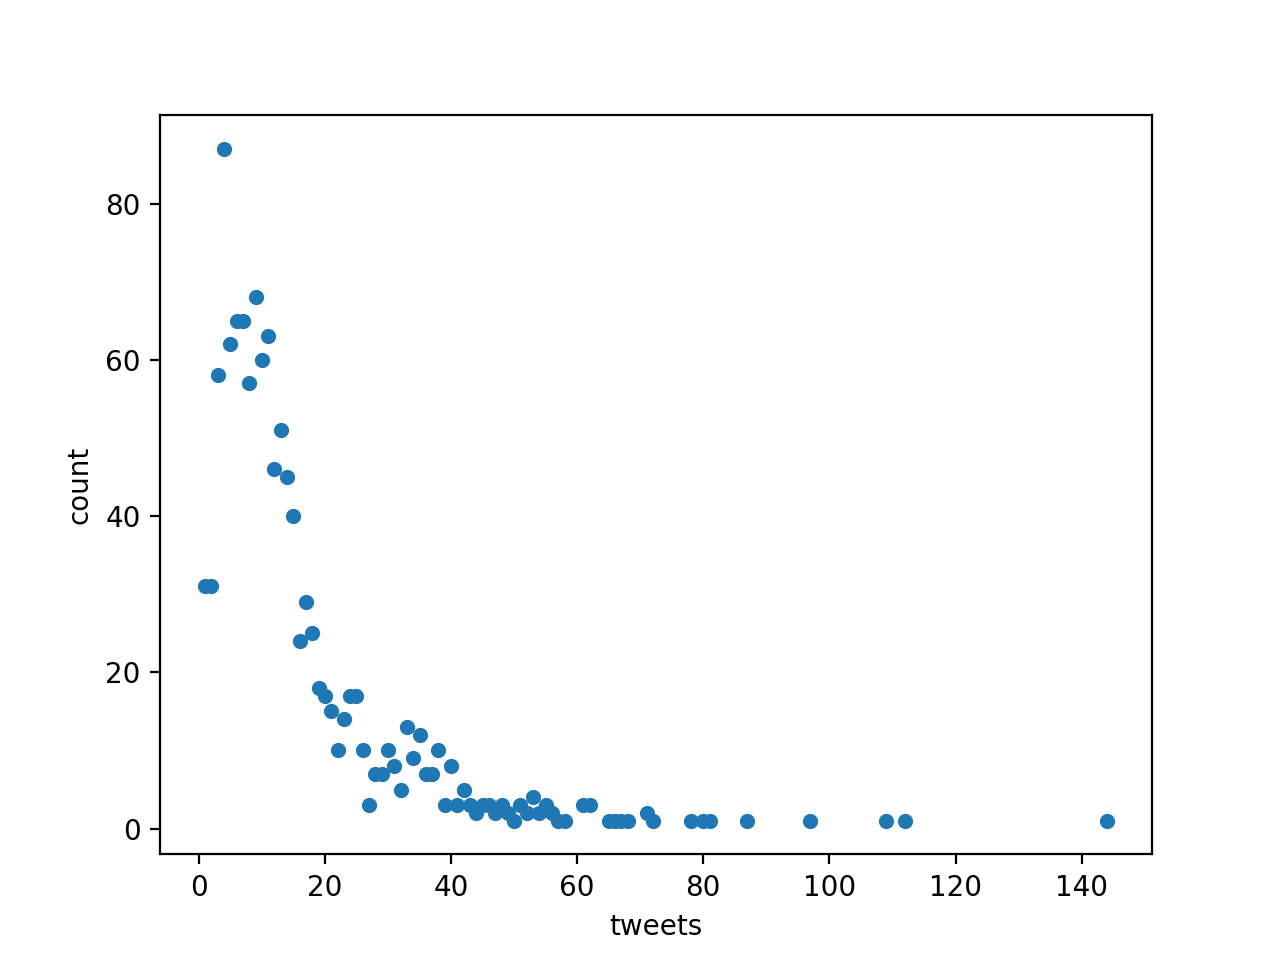

In [767]:
df.plot.scatter(x='tweets', y='count')

<IPython.core.display.Javascript object>


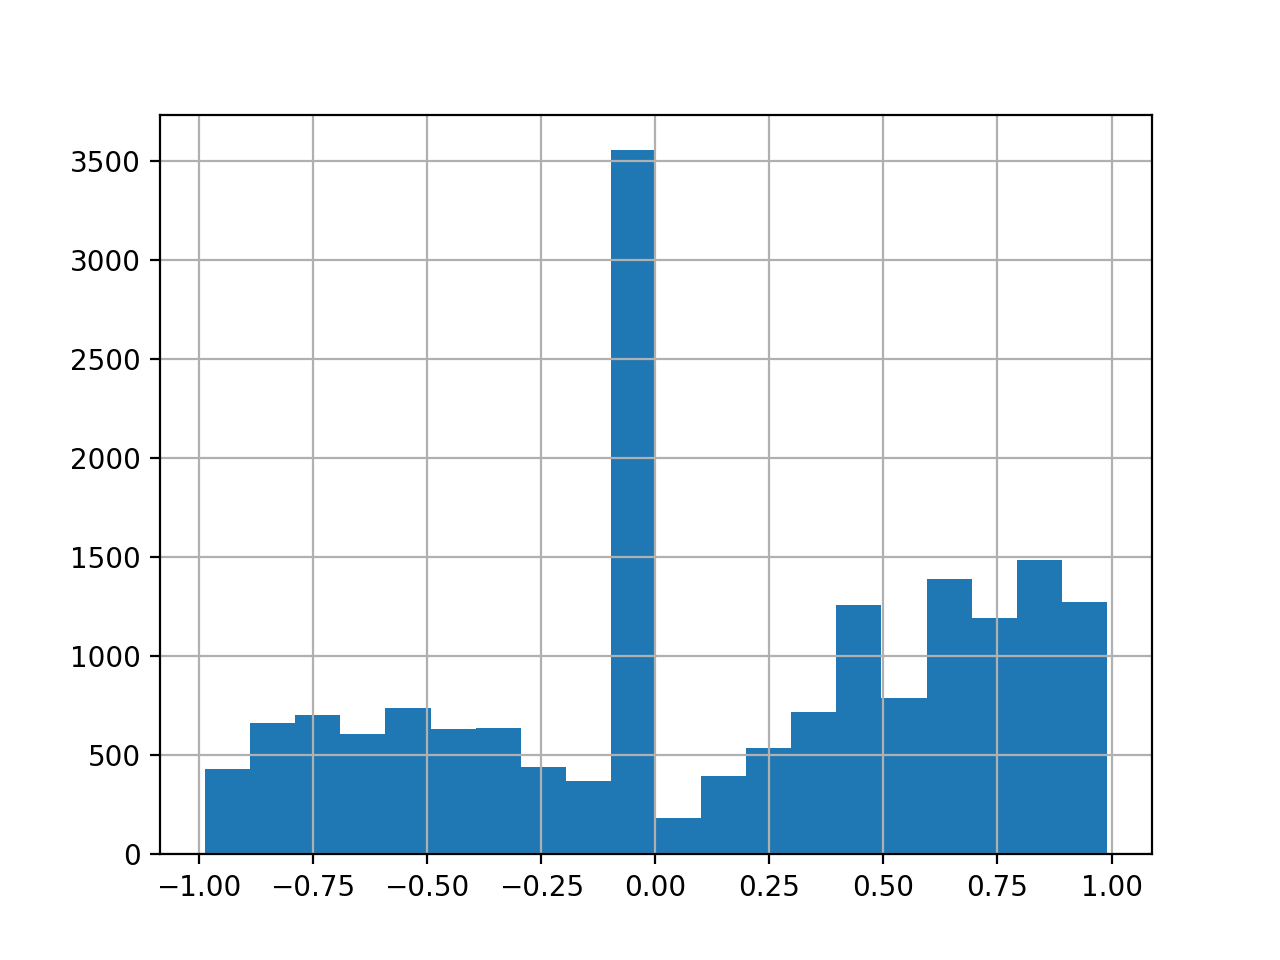

In [722]:
%matplotlib notebook
tweets['vader_compound'].hist(bins=20)

In [718]:
tweets.describe()

retweet_count  favorite_count        id_str          hour  \
count   18021.000000    18021.000000  1.802100e+04  18021.000000   
mean    17671.922646    58605.196770  1.114771e+18     12.622440   
std     12947.472670    59933.672427  1.180334e+17      6.703351   
min         0.000000        0.000000  8.224214e+17      0.000000   
25%      9684.000000        0.000000  1.034612e+18     10.000000   
50%     15390.000000    58083.000000  1.152526e+18     13.000000   
75%     22395.000000    91122.000000  1.208023e+18     18.000000   
max    369530.000000   879647.000000  1.261793e+18     23.000000   

           polarity  subjectivity     vader_neg     vader_neu     vader_pos  \
count  18021.000000  18021.000000  18021.000000  18021.000000  18021.000000   
mean       0.133856      0.418543      0.081007      0.731689      0.160057   
std        0.328630      0.302296      0.113608      0.214504      0.177563   
min       -1.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.100000      0.000000      0.640000      0.000000   
50%        0.022727      0.466667      0.000000      0.756000      0.118000   
75%        0.300000      0.638636      0.141000      0.870000      0.247000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       vader_compound  ...  vader_compound_45_days_rolling  \
count    18021.000000  ...                    18021.000000   
mean         0.152307  ...                        0.152736   
std          0.554580  ...                        0.064997   
min         -0.986400  ...                       -0.021955   
25%         -0.273200  ...                        0.093380   
50%          0.102700  ...                        0.154936   
75%          0.658800  ...                        0.196095   
max          0.989900  ...                        0.346803   

       polarity_60_days_rolling  vader_compound_60_days_rolling          djia  \
count              18021.000000                    18021.000000  18021.000000   
mean                   0.134758                        0.151854  25499.392726   
std                    0.030527                        0.061272   2351.939083   
min                    0.000000                       -0.021955  18591.930000   
25%                    0.111692                        0.094946  24174.820000   
50%                    0.133684                        0.156521  25877.330000   
75%                    0.159819                        0.190252  27081.360000   
max                    0.205982                        0.321524  29551.420000   

         djia_1_day   djia_1_week   djia_2_week   djia_3_week   djia_4_week  \
count  18021.000000  18021.000000  18021.000000  18021.000000  18021.000000   
mean      -0.007432      0.000463     -0.000572      0.000243      0.001585   
std        1.156879      0.035192      0.048335      0.059891      0.070354   
min       -5.328406     -0.188377     -0.265475     -0.303760     -0.338655   
25%       -0.314813     -0.007517     -0.009621     -0.007028     -0.009305   
50%        0.061443      0.004295      0.007022      0.010832      0.013498   
75%        0.444332      0.014830      0.021365      0.025110      0.032113   
max        5.514744      0.200923      0.219884      0.288180      0.238111   

       daily_tweet_count  
count       18021.000000  
mean           28.602797  
std            23.247327  
min             1.000000  
25%            12.000000  
50%            22.000000  
75%            38.000000  
max           144.000000  

[8 rows x 29 columns]

In [504]:
import datetime

tweets['impeachment'] = False

impeachment_start = datetime.datetime(2019,9,24)
impeachment_end = datetime.datetime(2020,1,6)

impeachment_mask= (tweets['created_at']>=impeachment_start) & (tweets['created_at']<=impeachment_end)

tweets.loc[impeachment_mask,'impeachment']=True

<IPython.core.display.Javascript object>


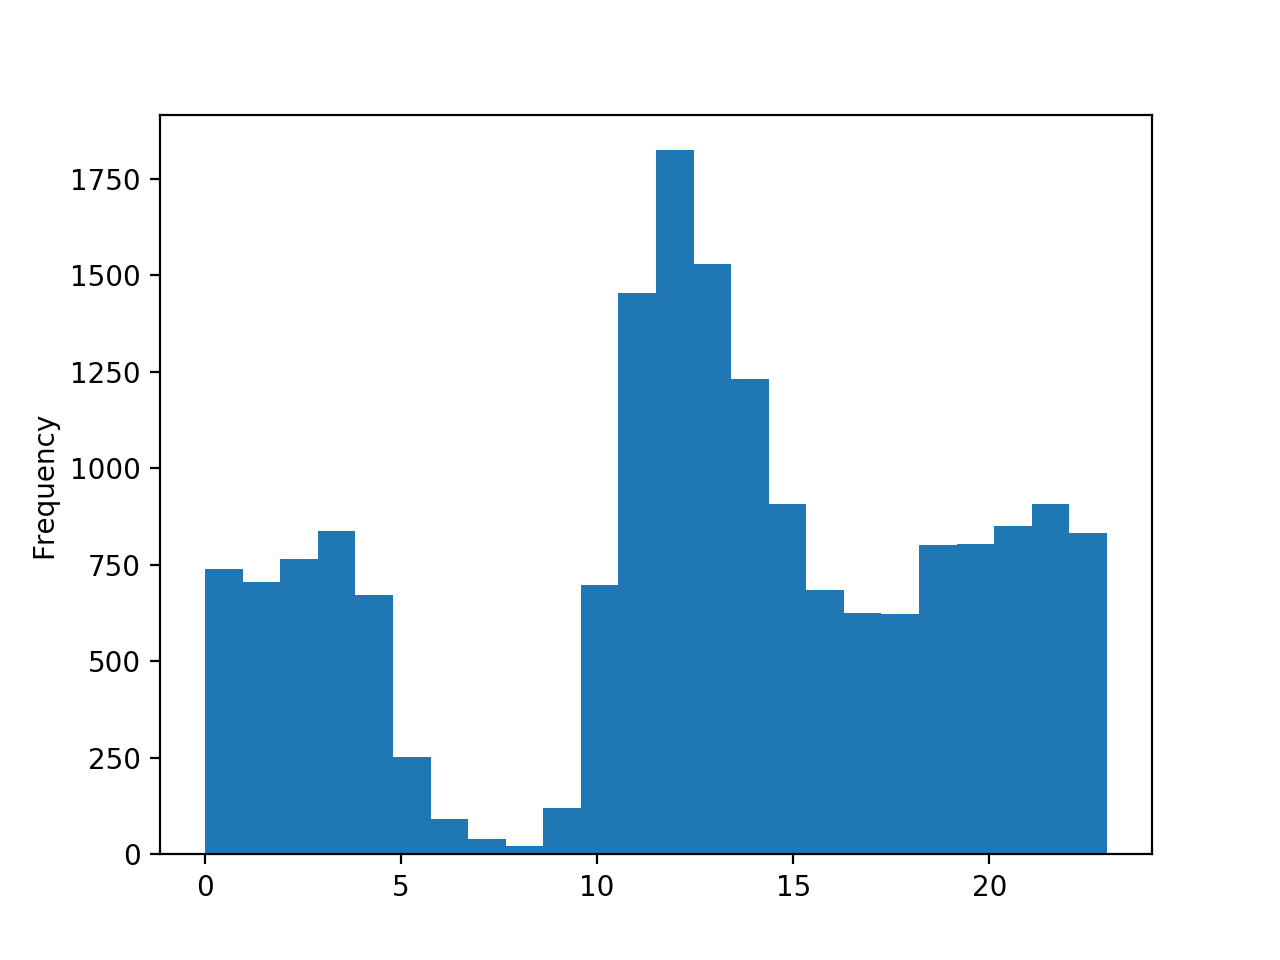

In [673]:
%matplotlib notebook
tweets['hour'].plot.hist(bins=24)

In [615]:
empty = tweets[tweets['clean_text']=='']
contain_text = tweets[tweets['clean_text']!='']

In [616]:
retweets = contain_text[contain_text['is_retweet']]
originals = contain_text[~contain_text['is_retweet']]

In [518]:
retweets.shape

(4071, 12)

In [519]:
originals.shape

(13480, 12)

In [520]:
empty.shape

(470, 12)

In [157]:
pivot= pd.pivot_table(contain_text, values=['clean_polarity','clean_subjectivity', 'vader_compound'], index=['hour'])
pivot.reset_index(inplace=True)
print(pivot)

    hour  clean_polarity  clean_subjectivity  vader_compound
0      0        0.170697            0.444486        0.221926
1      1        0.169992            0.424498        0.201896
2      2        0.154557            0.411429        0.167718
3      3        0.143806            0.414683        0.152138
4      4        0.121443            0.376087        0.157985
5      5        0.094270            0.371371        0.134134
6      6        0.075850            0.383249        0.117246
7      7        0.218789            0.476987        0.232597
8      8        0.141873            0.435097        0.166025
9      9        0.085541            0.390031        0.137672
10    10        0.102917            0.447659        0.090170
11    11        0.113111            0.429763        0.073343
12    12        0.111542            0.448348        0.086931
13    13        0.107634            0.452927        0.085755
14    14        0.126547            0.458121        0.106060
15    15        0.125318

<IPython.core.display.Javascript object>


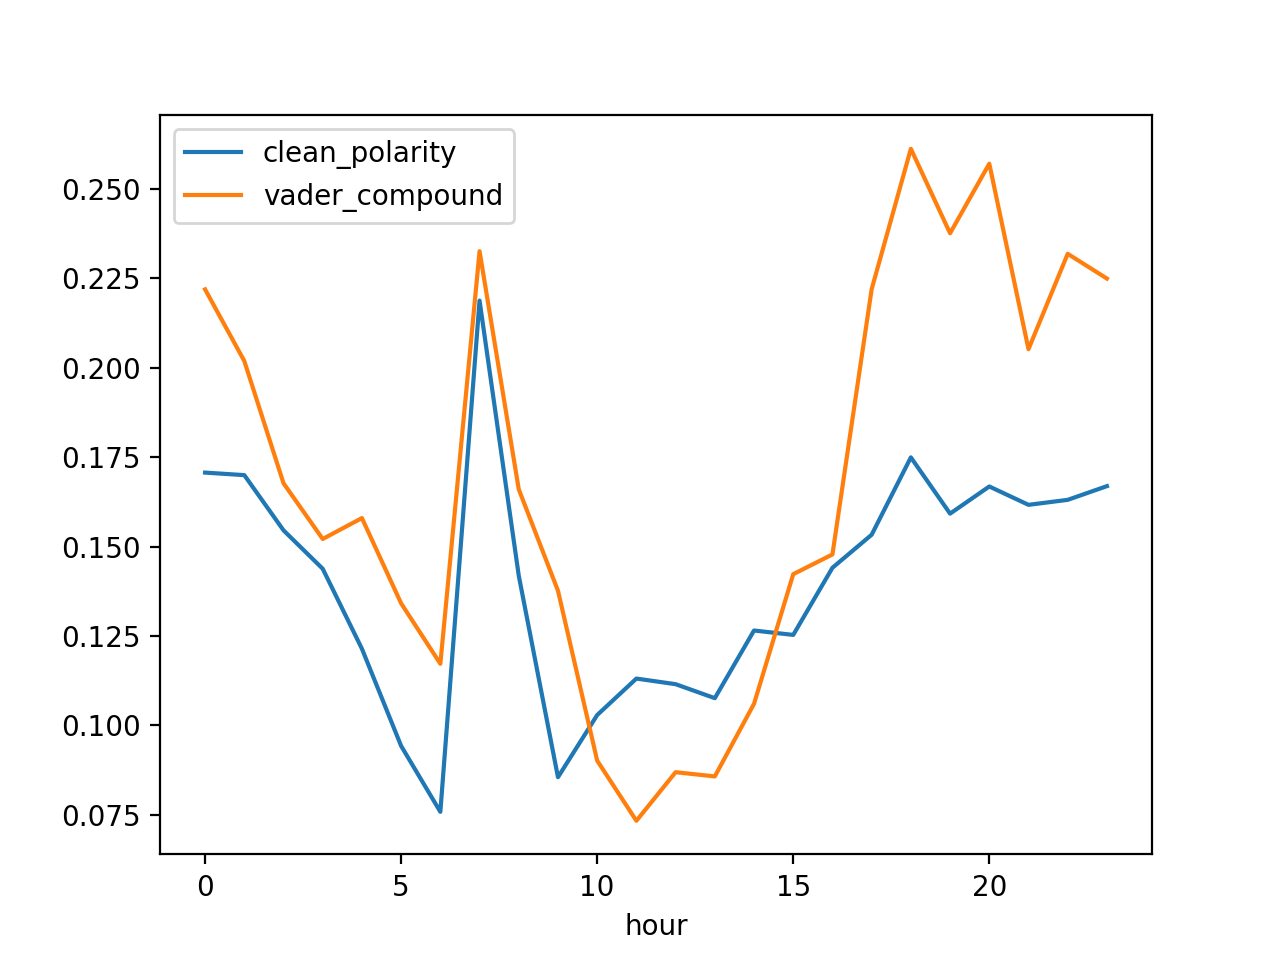

In [158]:
%matplotlib notebook

pivot.plot.line(x='hour', y=['clean_polarity', 'vader_compound'])

<IPython.core.display.Javascript object>


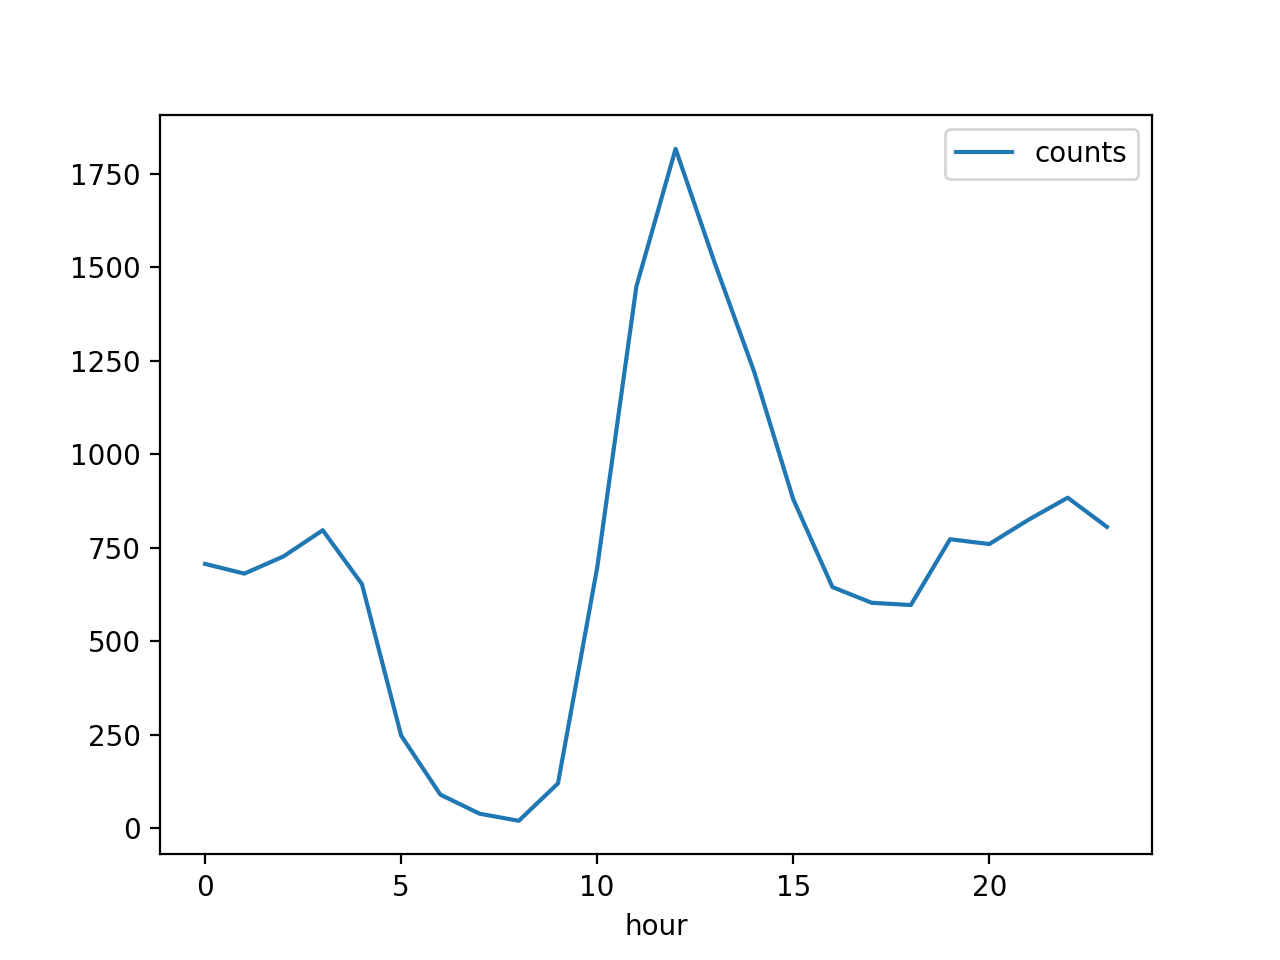

In [72]:
%matplotlib notebook
freq = contain_text['hour'].value_counts().rename_axis('hour').reset_index(name='counts')
freq.columns=freq.columns.str.strip()

freq.sort_values(by='hour', inplace=True)
freq.plot.line(x='hour', y='counts')

In [606]:
impeachment = tweets[tweets['impeachment']]
non_impeachment = tweets[~tweets['impeachment']]

In [629]:
positive = tweets[tweets['vader_compound']>0]
negative = tweets[tweets['vader_compound']<0]

In [535]:
tweets[['vader_compound','polarity']].corr()

vader_compound  polarity
vader_compound        1.000000  0.571023
polarity              0.571023  1.000000

<IPython.core.display.Javascript object>


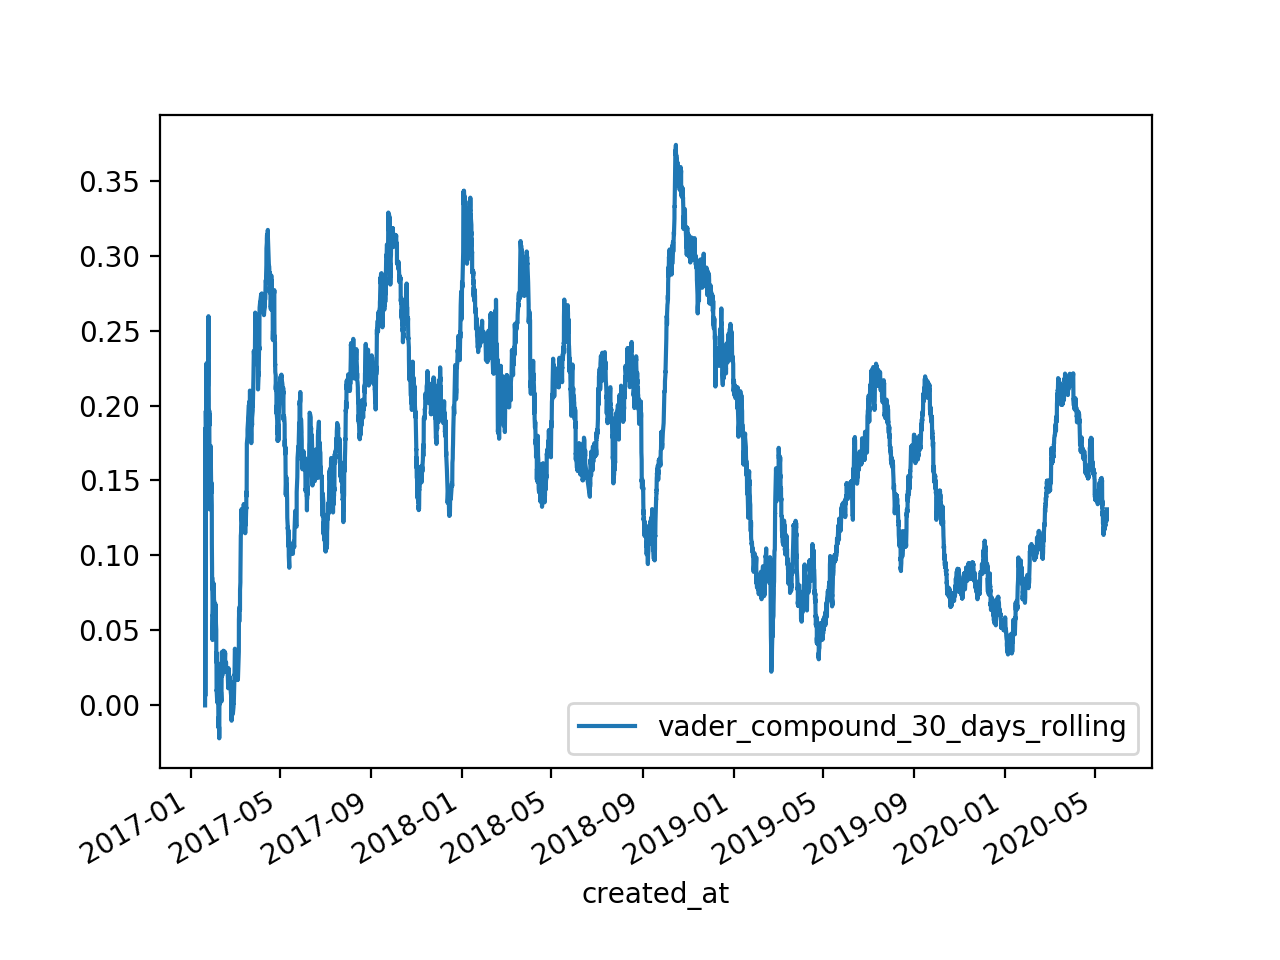

In [641]:
%matplotlib notebook
tweets.plot.line(x='created_at', y=['vader_compound_30_days_rolling'])

In [203]:
#f.get_figure().savefig('output.png')

<IPython.core.display.Javascript object>


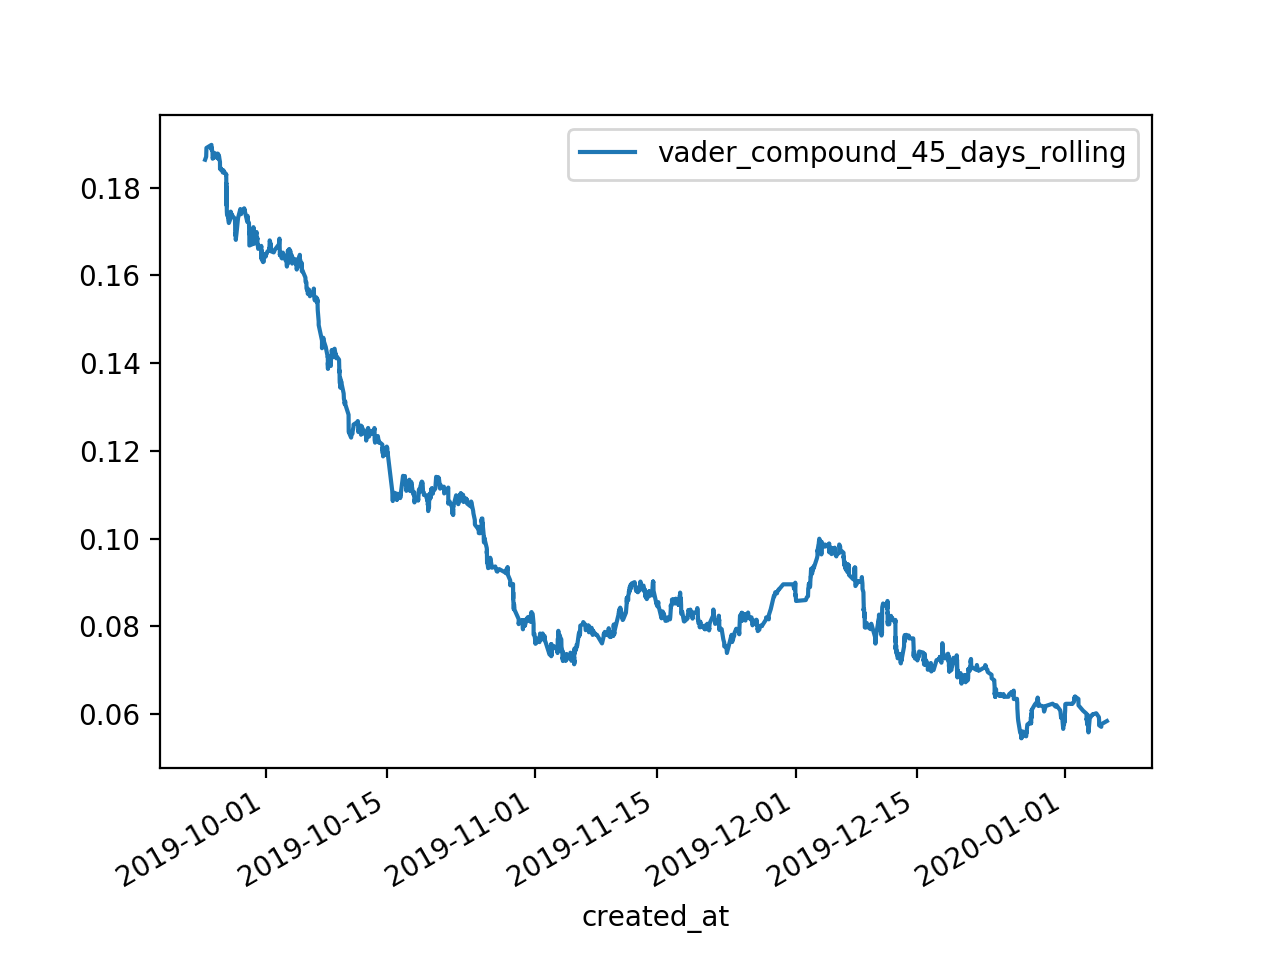

In [568]:
%matplotlib notebook
f = impeachment.plot.line(x='created_at', y=['vader_compound_45_days_rolling'])
f.get_figure().savefig('impeachment.png')

In [576]:
tweets.columns


Index(['source', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'is_retweet', 'id_str', 'hour', 'clean_text', 'polarity',
       'subjectivity', 'impeachment', 'vader', 'vader_neg', 'vader_neu',
       'vader_pos', 'vader_compound', 'polarity_3_days_rolling',
       'vader_compound_3_days_rolling', 'polarity_7_days_rolling',
       'vader_compound_7_days_rolling', 'polarity_15_days_rolling',
       'vader_compound_15_days_rolling', 'polarity_30_days_rolling',
       'vader_compound_30_days_rolling', 'polarity_45_days_rolling',
       'vader_compound_45_days_rolling', 'polarity_60_days_rolling',
       'vader_compound_60_days_rolling', 'djia', 'djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week'],
      dtype='object')

<IPython.core.display.Javascript object>


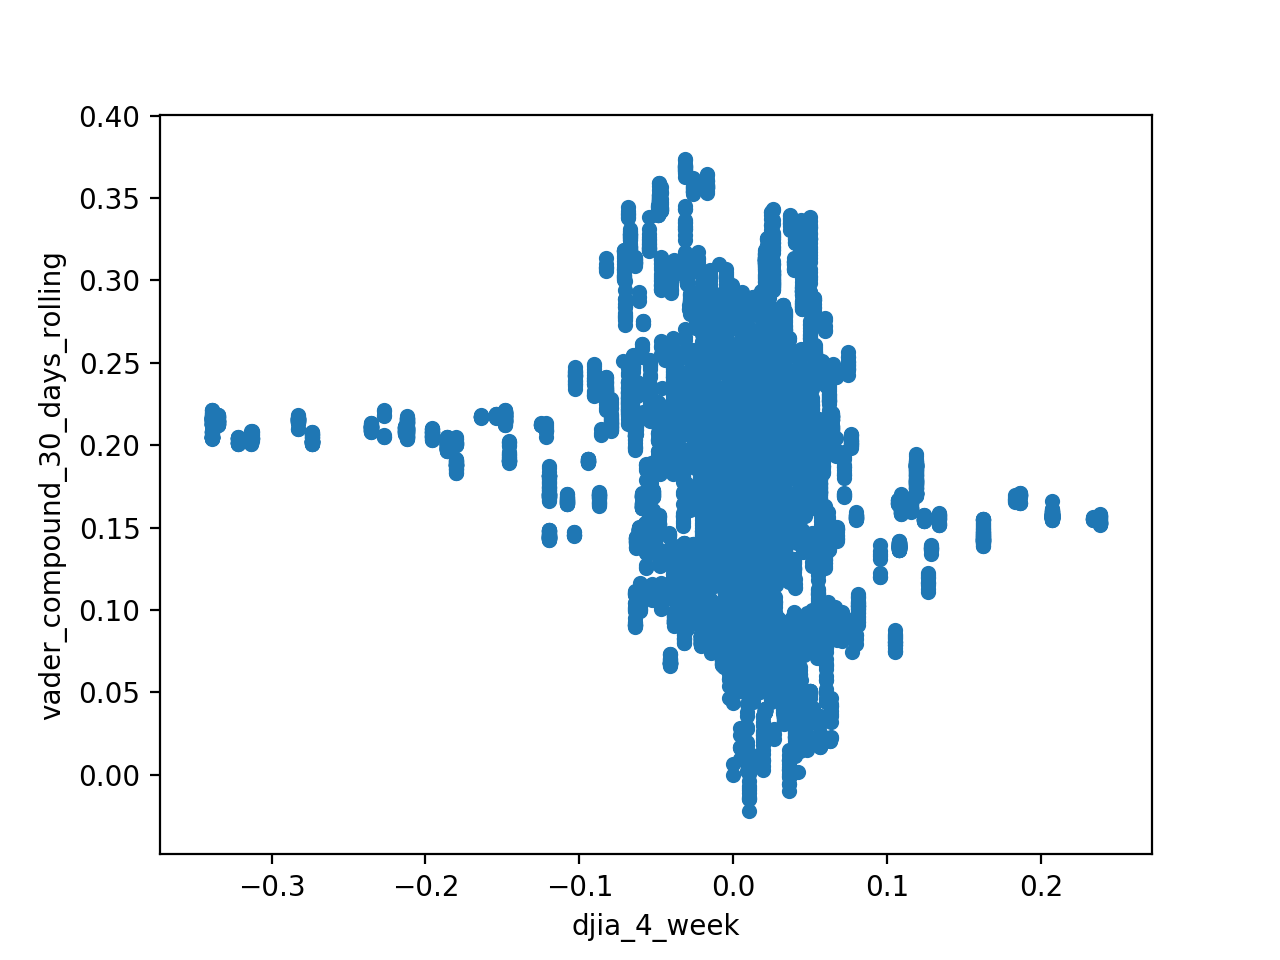

In [582]:
tweets.plot.scatter(x="djia_4_week", y="vader_compound_30_days_rolling")

In [668]:
tweets[[
       'vader_compound_3_days_rolling',
       'vader_compound_7_days_rolling',
       'vader_compound_15_days_rolling',
       'vader_compound_30_days_rolling',
       'vader_compound_45_days_rolling',
       'vader_compound_60_days_rolling', 'djia', 'djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week', 'daily_tweet_count']].corr()[['djia', 'djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week', 'daily_tweet_count']]

djia  djia_1_day  djia_1_week  \
vader_compound_3_days_rolling  -0.204944   -0.032696    -0.089332   
vader_compound_7_days_rolling  -0.276066   -0.057465    -0.089620   
vader_compound_15_days_rolling -0.377693   -0.057543    -0.123547   
vader_compound_30_days_rolling -0.471369   -0.042975    -0.072074   
vader_compound_45_days_rolling -0.496614   -0.035976    -0.015223   
vader_compound_60_days_rolling -0.486876   -0.024504     0.033282   
djia                            1.000000    0.112138     0.201255   
djia_1_day                      0.112138    1.000000     0.314233   
djia_1_week                     0.201255    0.314233     1.000000   
djia_2_week                     0.268837    0.312111     0.714704   
djia_3_week                     0.303878    0.220195     0.652815   
djia_4_week                     0.342669    0.226364     0.596690   
daily_tweet_count               0.341167   -0.034282    -0.046241   

                                djia_2_week  djia_3_week  djia_4_week  \
vader_compound_3_days_rolling     -0.080335    -0.109377    -0.117168   
vader_compound_7_days_rolling     -0.109740    -0.132832    -0.153539   
vader_compound_15_days_rolling    -0.155080    -0.173857    -0.190711   
vader_compound_30_days_rolling    -0.132381    -0.171226    -0.195855   
vader_compound_45_days_rolling    -0.057018    -0.091127    -0.128140   
vader_compound_60_days_rolling     0.002378    -0.023195    -0.047444   
djia                               0.268837     0.303878     0.342669   
djia_1_day                         0.312111     0.220195     0.226364   
djia_1_week                        0.714704     0.652815     0.596690   
djia_2_week                        1.000000     0.830281     0.770612   
djia_3_week                        0.830281     1.000000     0.889321   
djia_4_week                        0.770612     0.889321     1.000000   
daily_tweet_count                 -0.081136    -0.067268    -0.050773   

                                daily_tweet_count  
vader_compound_3_days_rolling           -0.217252  
vader_compound_7_days_rolling           -0.225189  
vader_compound_15_days_rolling          -0.284437  
vader_compound_30_days_rolling          -0.345841  
vader_compound_45_days_rolling          -0.373973  
vader_compound_60_days_rolling          -0.386707  
djia                                     0.341167  
djia_1_day                              -0.034282  
djia_1_week                             -0.046241  
djia_2_week                             -0.081136  
djia_3_week                             -0.067268  
djia_4_week                             -0.050773  
daily_tweet_count                        1.000000

In [591]:
djia.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Week Change',
       'Two Week Change', 'Three Week Change', 'One Month Change',
       'Daily_Percent_Inc'],
      dtype='object')

In [715]:
down = tweets[tweets['djia_4_week']<-.025]
up = tweets[tweets['djia_4_week']>.025]

up_days = len(djia[djia['One Month Change']>.025])
down_days = len(djia[djia['One Month Change']<-.025])


print(down_days)
down.describe()

142


retweet_count  favorite_count        id_str         hour     polarity  \
count    3401.000000     3401.000000  3.401000e+03  3401.000000  3401.000000   
mean    17608.154366    59948.959718  1.150103e+18    12.541311     0.144332   
std     12053.142820    60387.231923  8.725645e+16     6.737525     0.324341   
min         0.000000        0.000000  9.603610e+17     0.000000    -1.000000   
25%      9909.000000        0.000000  1.075367e+18     9.000000     0.000000   
50%     15319.000000    58652.000000  1.162845e+18    13.000000     0.050000   
75%     22193.000000    91649.000000  1.237406e+18    18.000000     0.312500   
max    115581.000000   628164.000000  1.247656e+18    23.000000     1.000000   

       subjectivity    vader_neg    vader_neu    vader_pos  vader_compound  \
count   3401.000000  3401.000000  3401.000000  3401.000000     3401.000000   
mean       0.430132     0.075828     0.723615     0.173214        0.199953   
std        0.296400     0.109743     0.209804     0.175374        0.559032   
min        0.000000     0.000000     0.000000     0.000000       -0.978300   
25%        0.166667     0.000000     0.638000     0.000000       -0.177900   
50%        0.482589     0.000000     0.748000     0.135000        0.296000   
75%        0.644444     0.129000     0.856000     0.263000        0.700300   
max        1.000000     1.000000     1.000000     1.000000        0.989900   

       ...  vader_compound_45_days_rolling  polarity_60_days_rolling  \
count  ...                     3401.000000               3401.000000   
mean   ...                        0.184689                  0.143400   
std    ...                        0.061968                  0.022386   
min    ...                        0.069286                  0.111192   
25%    ...                        0.134759                  0.122984   
50%    ...                        0.181594                  0.139851   
75%    ...                        0.222028                  0.163371   
max    ...                        0.344209                  0.192382   

       vader_compound_60_days_rolling          djia   djia_1_day  djia_1_week  \
count                     3401.000000   3401.000000  3401.000000  3401.000000   
mean                         0.177491  24221.388653    -0.288467    -0.027116   
std                          0.056285   2182.838100     2.286967     0.063725   
min                          0.074898  18591.930000    -5.328406    -0.188377   
25%                          0.144126  23138.820000    -1.556635    -0.046673   
50%                          0.164761  25052.830000    -0.266219    -0.015271   
75%                          0.222977  25776.610000     0.749419     0.008872   
max                          0.319597  27960.800000     5.514744     0.200923   

       djia_2_week  djia_3_week  djia_4_week  daily_tweet_count  
count  3401.000000  3401.000000  3401.000000        3401.000000  
mean     -0.054218    -0.081613    -0.099785          27.128786  
std       0.081220     0.080570     0.091079          17.379853  
min      -0.265475    -0.303760    -0.338655           1.000000  
25%      -0.083698    -0.120943    -0.145462          14.000000  
50%      -0.037769    -0.048044    -0.057499          23.000000  
75%      -0.013082    -0.032324    -0.038621          36.000000  
max       0.219884     0.123410    -0.025208          87.000000  

[8 rows x 29 columns]

In [716]:
print(up_days)
up.describe()

275


retweet_count  favorite_count        id_str         hour     polarity  \
count    5936.000000     5936.000000  5.936000e+03  5936.000000  5936.000000   
mean    18148.284367    60178.327830  1.122469e+18    12.610681     0.132914   
std     12732.529992    63264.176366  1.176544e+17     6.809841     0.325796   
min         0.000000        0.000000  8.311693e+17     0.000000    -1.000000   
25%     10102.750000        0.000000  1.039527e+18    10.000000     0.000000   
50%     15729.000000    57752.500000  1.155141e+18    13.000000     0.023964   
75%     23056.250000    93153.250000  1.213115e+18    18.000000     0.300000   
max    201773.000000   814012.000000  1.259971e+18    23.000000     1.000000   

       subjectivity    vader_neg    vader_neu    vader_pos  vader_compound  \
count   5936.000000  5936.000000  5936.000000  5936.000000     5936.000000   
mean       0.412496     0.079877     0.729552     0.158733        0.149075   
std        0.302254     0.112702     0.223249     0.181598        0.547858   
min        0.000000     0.000000     0.000000     0.000000       -0.986400   
25%        0.075000     0.000000     0.637000     0.000000       -0.270200   
50%        0.454545     0.000000     0.758000     0.115000        0.051600   
75%        0.633413     0.138000     0.874000     0.245000        0.656025   
max        1.000000     1.000000     1.000000     1.000000        0.985600   

       ...  vader_compound_45_days_rolling  polarity_60_days_rolling  \
count  ...                     5936.000000               5936.000000   
mean   ...                        0.150515                  0.133959   
std    ...                        0.065741                  0.032162   
min    ...                        0.021811                  0.062090   
25%    ...                        0.082056                  0.103277   
50%    ...                        0.162609                  0.131824   
75%    ...                        0.195476                  0.160751   
max    ...                        0.340726                  0.205982   

       vader_compound_60_days_rolling          djia   djia_1_day  djia_1_week  \
count                     5936.000000   5936.000000  5936.000000  5936.000000   
mean                         0.152436  25857.397273     0.144461     0.013011   
std                          0.058661   2014.653619     0.571235     0.019466   
min                          0.021811  20412.200000    -1.845437    -0.039345   
25%                          0.097894  24242.490000    -0.109928     0.003124   
50%                          0.167902  26120.110000     0.133449     0.011251   
75%                          0.189756  27332.030000     0.469869     0.019141   
max                          0.304920  29348.100000     1.785856     0.107686   

       djia_2_week  djia_3_week  djia_4_week  daily_tweet_count  
count  5936.000000  5936.000000  5936.000000        5936.000000  
mean      0.023206     0.036785     0.052616          29.416105  
std       0.022408     0.034933     0.038813          26.760966  
min      -0.021400    -0.004217     0.025052           1.000000  
25%       0.011657     0.020698     0.032243          13.000000  
50%       0.021399     0.025924     0.040187          21.000000  
75%       0.030364     0.039047     0.053047          38.000000  
max       0.132116     0.288180     0.238111         144.000000  

[8 rows x 29 columns]

<IPython.core.display.Javascript object>


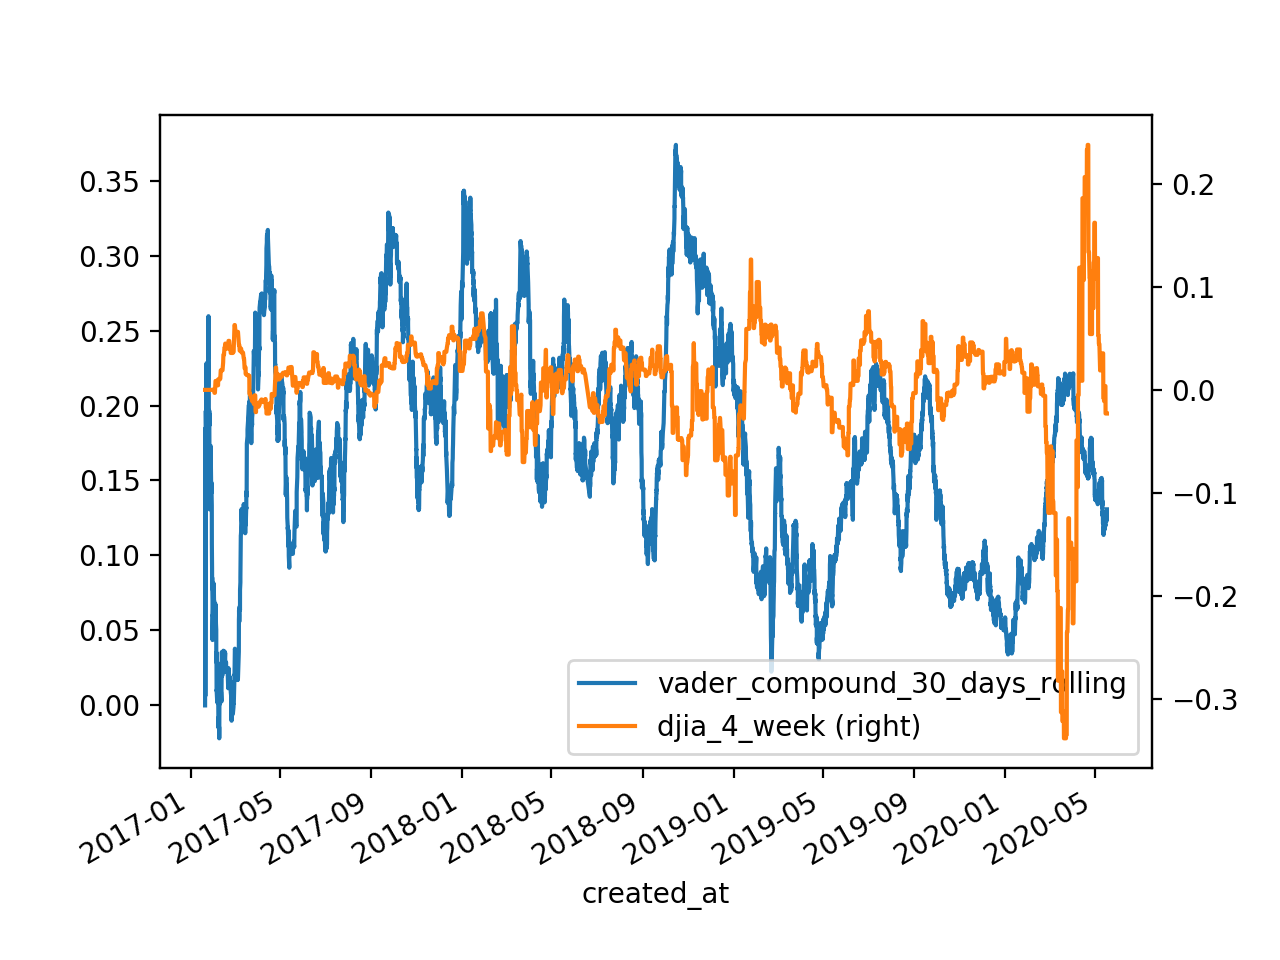

In [605]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1)
tweets.plot.line(x='created_at', y='vader_compound_30_days_rolling', ax=ax)
f=tweets.plot.line(x='created_at',y='djia_4_week', secondary_y=True, ax=ax)

f.get_figure().savefig('market_and_sentiment.png')

In [609]:
from scipy import stats

impeachment_sent = impeachment['vader_compound']
non_impeachment_sent = non_impeachment['vader_compound']

ttest,pval = stats.ttest_ind(impeachment_sent, non_impeachment_sent)
print(pval)


7.301192355532328e-22


In [610]:
impeachment_sent.describe()

count    3341.000000
mean        0.069197
std         0.509042
min        -0.968900
25%        -0.301600
50%         0.000000
75%         0.492600
max         0.983100
Name: vader_compound, dtype: float64

In [611]:
non_impeachment_sent.describe()

count    14680.000000
mean         0.171222
std          0.562735
min         -0.986400
25%         -0.261700
50%          0.202300
75%          0.670500
max          0.989900
Name: vader_compound, dtype: float64

In [614]:
from scipy import stats

up_sent = up['vader_compound']
down_sent = down['vader_compound']

ttest,pval = stats.ttest_ind(up_sent, down_sent)
print(pval)

1.8353873160924917e-05


In [619]:
retweets_sent = retweets['vader_compound']
originals_sent = originals['vader_compound']

ttest,pval = stats.ttest_ind(retweets_sent, originals_sent)
print(pval)

1.5214568191862436e-19


In [620]:
retweets_sent.describe()

count    4071.000000
mean        0.086732
std         0.449254
min        -0.968100
25%        -0.177900
50%         0.000000
75%         0.440400
max         0.960000
Name: vader_compound, dtype: float64

In [621]:
originals_sent.describe()

count    13480.000000
mean         0.177421
std          0.589485
min         -0.986400
25%         -0.338200
50%          0.296000
75%          0.711975
max          0.989900
Name: vader_compound, dtype: float64

In [627]:
originals[[
       'vader_compound_3_days_rolling',
       'vader_compound_7_days_rolling',
       'vader_compound_15_days_rolling',
       'vader_compound_30_days_rolling',
       'vader_compound_45_days_rolling',
       'vader_compound_60_days_rolling', 'djia', 'djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week']].corr()[['djia', 'djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week']]

djia  djia_1_day  djia_1_week  \
vader_compound_3_days_rolling  -0.157193   -0.028130    -0.053335   
vader_compound_7_days_rolling  -0.225164   -0.058526    -0.067612   
vader_compound_15_days_rolling -0.302517   -0.045738    -0.080757   
vader_compound_30_days_rolling -0.371121   -0.031962    -0.037821   
vader_compound_45_days_rolling -0.392748   -0.042135    -0.006956   
vader_compound_60_days_rolling -0.392966   -0.053351     0.012554   
djia                            1.000000    0.047890     0.098538   
djia_1_day                      0.047890    1.000000     0.228998   
djia_1_week                     0.098538    0.228998     1.000000   
djia_2_week                     0.169897    0.213186     0.661032   
djia_3_week                     0.196730    0.126308     0.573138   
djia_4_week                     0.230689    0.119738     0.486814   

                                djia_2_week  djia_3_week  djia_4_week  
vader_compound_3_days_rolling     -0.036854    -0.072263    -0.067497  
vader_compound_7_days_rolling     -0.080490    -0.102716    -0.117043  
vader_compound_15_days_rolling    -0.113152    -0.130825    -0.144209  
vader_compound_30_days_rolling    -0.100147    -0.137870    -0.158423  
vader_compound_45_days_rolling    -0.049587    -0.082529    -0.116988  
vader_compound_60_days_rolling    -0.026141    -0.052063    -0.077578  
djia                               0.169897     0.196730     0.230689  
djia_1_day                         0.213186     0.126308     0.119738  
djia_1_week                        0.661032     0.573138     0.486814  
djia_2_week                        1.000000     0.816476     0.726773  
djia_3_week                        0.816476     1.000000     0.863725  
djia_4_week                        0.726773     0.863725     1.000000

<IPython.core.display.Javascript object>


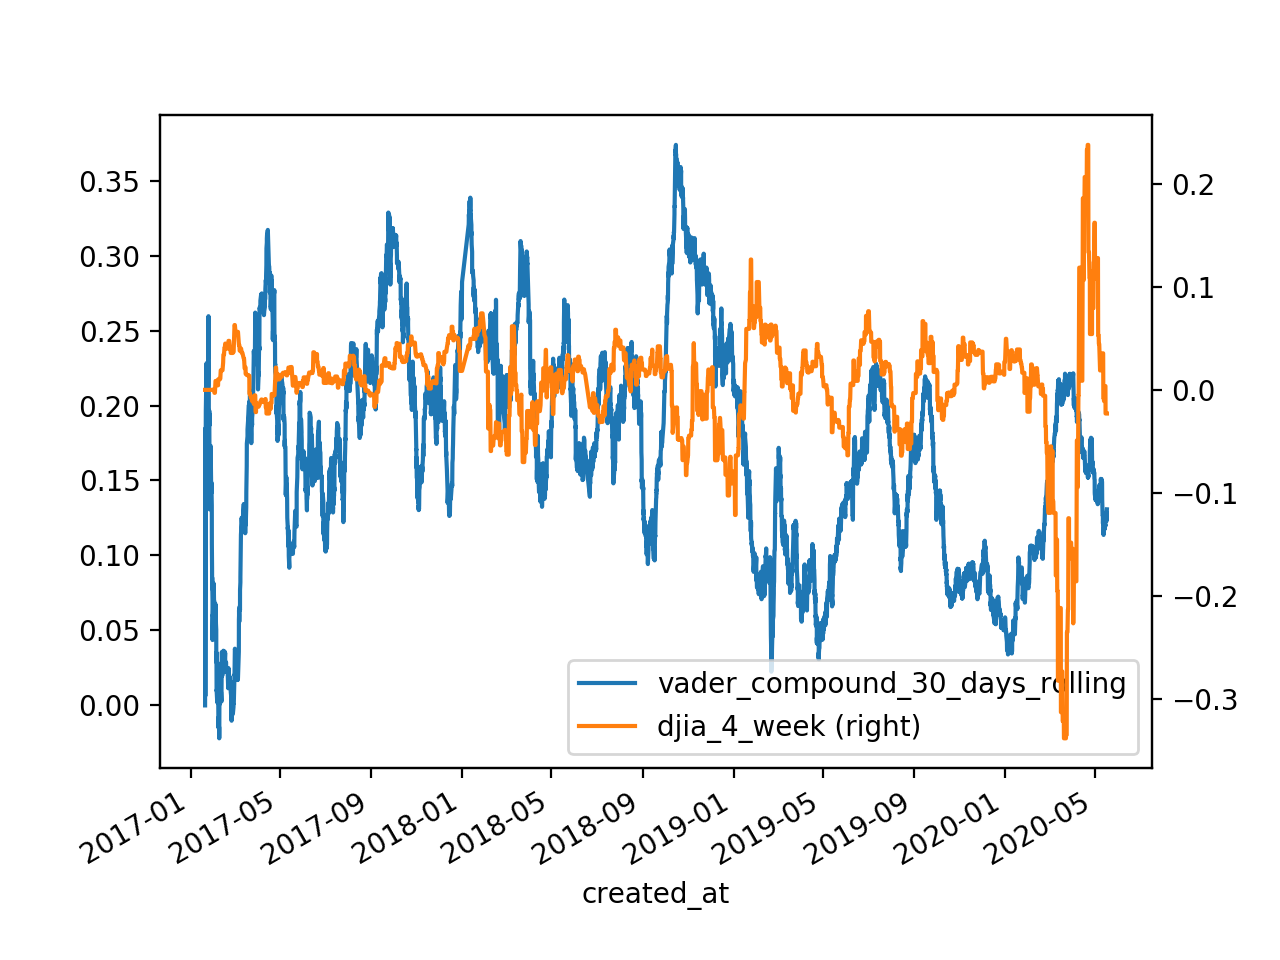

In [702]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1)
originals.plot.line(x='created_at', y='vader_compound_30_days_rolling', ax=ax)
f=originals.plot.line(x='created_at',y='djia_4_week', secondary_y=True, ax=ax)

In [632]:
positive.describe()

retweet_count  favorite_count        id_str         hour     polarity  \
count    9235.000000     9235.000000  9.235000e+03  9235.000000  9235.000000   
mean    17401.901787    63702.099621  1.104944e+18    12.828262     0.288985   
std     12366.528830    60048.141363  1.197787e+17     6.823922     0.322720   
min         0.000000        0.000000  8.225018e+17     0.000000    -1.000000   
25%     10052.500000        0.000000  1.019727e+18    10.000000     0.000000   
50%     15222.000000    62723.000000  1.138572e+18    13.000000     0.250000   
75%     21602.000000    92571.500000  1.205108e+18    19.000000     0.495417   
max    272776.000000   764333.000000  1.261793e+18    23.000000     1.000000   

       subjectivity    vader_neg    vader_neu    vader_pos  vader_compound  \
count   9235.000000  9235.000000  9235.000000  9235.000000     9235.000000   
mean       0.481684     0.033362     0.684174     0.282462        0.614911   
std        0.278711     0.053883     0.164903     0.167600        0.242586   
min        0.000000     0.000000     0.000000     0.026000        0.003800   
25%        0.310764     0.000000     0.601000     0.162000        0.419900   
50%        0.502381     0.000000     0.713000     0.241000        0.658100   
75%        0.686753     0.062000     0.803000     0.355000        0.822500   
max        1.000000     0.407000     0.974000     1.000000        0.989900   

       ...  polarity_45_days_rolling  vader_compound_45_days_rolling  \
count  ...               9235.000000                     9235.000000   
mean   ...                  0.138584                        0.159998   
std    ...                  0.031443                        0.065842   
min    ...                  0.034586                       -0.014173   
25%    ...                  0.114349                        0.101799   
50%    ...                  0.138617                        0.164031   
75%    ...                  0.164310                        0.201652   
max    ...                  0.210642                        0.346803   

       polarity_60_days_rolling  vader_compound_60_days_rolling          djia  \
count               9235.000000                     9235.000000   9235.000000   
mean                   0.138246                        0.158466  25344.899859   
std                    0.030371                        0.062007   2326.993830   
min                    0.034586                       -0.014173  18591.930000   
25%                    0.115340                        0.102846  23949.760000   
50%                    0.139573                        0.164380  25669.320000   
75%                    0.163450                        0.195185  26916.830000   
max                    0.205982                        0.321524  29551.420000   

        djia_1_day  djia_1_week  djia_2_week  djia_3_week  djia_4_week  
count  9235.000000  9235.000000  9235.000000  9235.000000  9235.000000  
mean     -0.018977    -0.000370    -0.001891    -0.001823    -0.000435  
std       1.185134     0.035915     0.049486     0.060757     0.071458  
min      -5.328406    -0.188377    -0.265475    -0.303760    -0.338655  
25%      -0.320907    -0.008759    -0.010863    -0.010901    -0.014803  
50%       0.051138     0.004118     0.006629     0.010538     0.013008  
75%       0.444332     0.014458     0.021082     0.024401     0.032113  
max       5.514744     0.200923     0.219884     0.288180     0.238111  

[8 rows x 28 columns]

In [633]:
negative.describe()

retweet_count  favorite_count        id_str         hour     polarity  \
count    5399.000000     5399.000000  5.399000e+03  5399.000000  5399.000000   
mean    19524.382663    63508.221152  1.114741e+18    12.457677    -0.069383   
std     12040.141134    58642.825705  1.159737e+17     6.219644     0.278364   
min         0.000000        0.000000  8.225025e+17     0.000000    -1.000000   
25%     11290.500000        0.000000  1.035135e+18    10.000000    -0.200000   
50%     18271.000000    69178.000000  1.150720e+18    13.000000     0.000000   
75%     25303.000000    99794.500000  1.206269e+18    16.000000     0.052178   
max    251530.000000   879647.000000  1.261793e+18    23.000000     1.000000   

       subjectivity    vader_neg    vader_neu    vader_pos  vader_compound  \
count   5399.000000  5399.000000  5399.000000  5399.000000     5399.000000   
mean       0.462474     0.212425     0.737352     0.050224       -0.543430   
std        0.286822     0.113367     0.127628     0.059812        0.247456   
min        0.000000     0.027000     0.000000     0.000000       -0.986400   
25%        0.281458     0.135500     0.668000     0.000000       -0.756900   
50%        0.500000     0.192000     0.752000     0.028000       -0.549700   
75%        0.657738     0.261000     0.829000     0.092000       -0.353200   
max        1.000000     1.000000     0.973000     0.457000       -0.001800   

       ...  polarity_45_days_rolling  vader_compound_45_days_rolling  \
count  ...               5399.000000                     5399.000000   
mean   ...                  0.133299                        0.147216   
std    ...                  0.031885                        0.064747   
min    ...                  0.035262                       -0.021955   
25%    ...                  0.111254                        0.087854   
50%    ...                  0.132808                        0.149389   
75%    ...                  0.158229                        0.191849   
max    ...                  0.209713                        0.345199   

       polarity_60_days_rolling  vader_compound_60_days_rolling          djia  \
count               5399.000000                     5399.000000   5399.000000   
mean                   0.133436                        0.147622  25607.976336   
std                    0.030842                        0.061684   2311.650967   
min                    0.035262                       -0.021955  18591.930000   
25%                    0.110099                        0.090120  24283.110000   
50%                    0.132118                        0.151543  25942.370000   
75%                    0.158795                        0.188885  27154.200000   
max                    0.205017                        0.320660  29551.420000   

        djia_1_day  djia_1_week  djia_2_week  djia_3_week  djia_4_week  
count  5399.000000  5399.000000  5399.000000  5399.000000  5399.000000  
mean      0.013768     0.001506     0.000826     0.002592     0.004306  
std       1.062800     0.032390     0.043917     0.055853     0.064051  
min      -5.328406    -0.188377    -0.265475    -0.303760    -0.338655  
25%      -0.279547    -0.006876    -0.007481    -0.006660    -0.007676  
50%       0.071453     0.004474     0.007071     0.011592     0.014434  
75%       0.430856     0.014911     0.021377     0.025390     0.031213  
max       5.514744     0.200923     0.219884     0.288180     0.238111  

[8 rows x 28 columns]

In [634]:
positive_retweet = positive['retweet_count']
negative_retweet = negative['retweet_count']

ttest,pval = stats.ttest_ind(positive_retweet, negative_retweet)
print(pval)

5.633888223494895e-24


In [635]:
positive_favorite = positive['favorite_count']
negative_favorite = negative['favorite_count']

ttest,pval = stats.ttest_ind(positive_favorite, negative_favorite)
print(pval)

0.8492405355550736


<IPython.core.display.Javascript object>


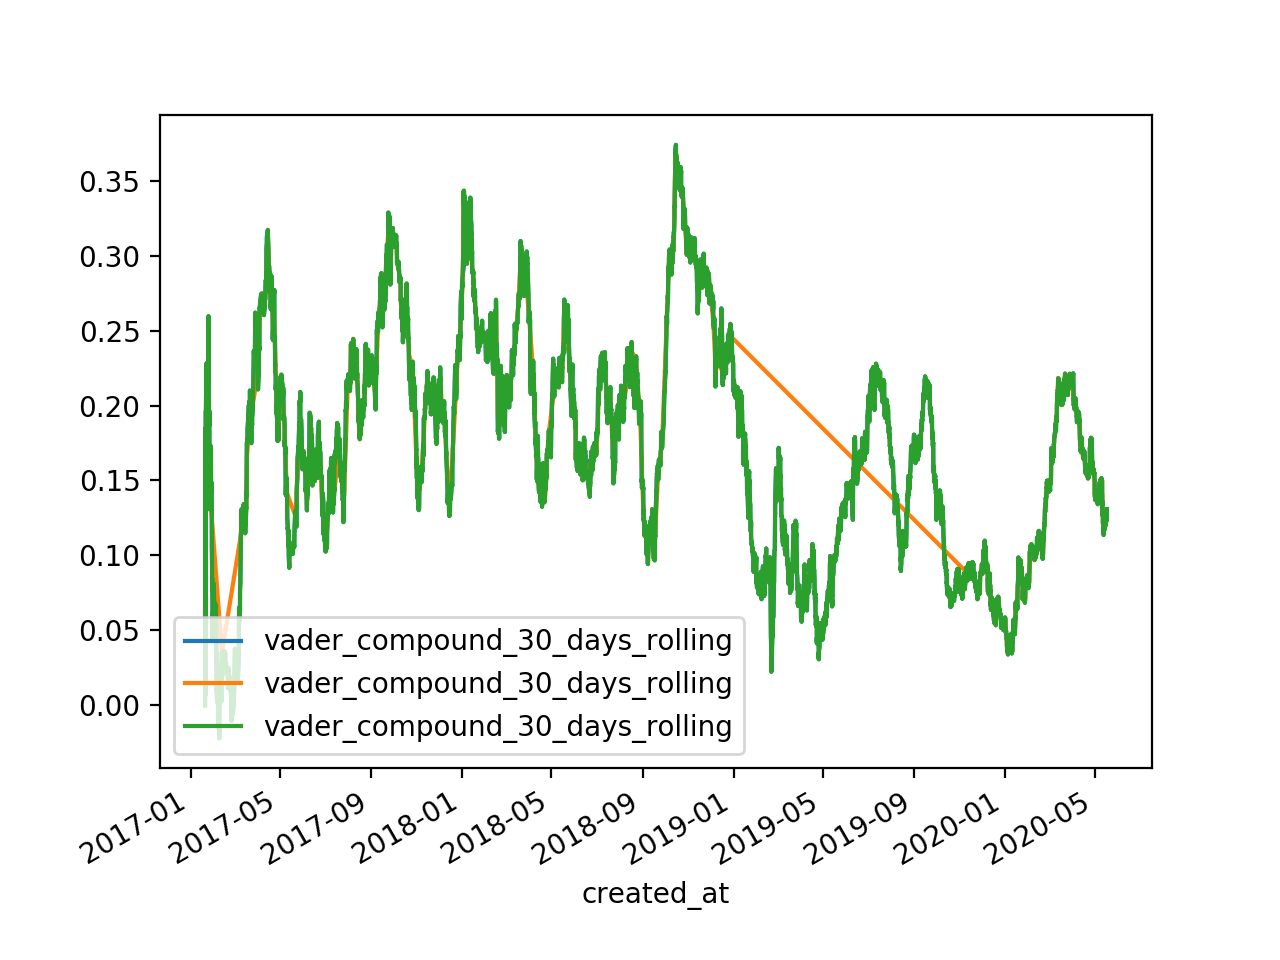

In [651]:

fig, ax = plt.subplots(1, 1)
originals.plot.line(x='created_at', y='vader_compound_30_days_rolling', ax=ax)
f=retweets.plot.line(x='created_at',y='vader_compound_30_days_rolling', secondary_y=False, ax=ax)
tweets.plot.line(x='created_at',y='vader_compound_30_days_rolling', secondary_y=False, ax=ax)

# originals.plot.line(x='created_at', y=['vader_compound_30_days_rolling'])
# retweets.plot.line(x='created_at', y=['vader_compound_30_days_rolling'])

<IPython.core.display.Javascript object>


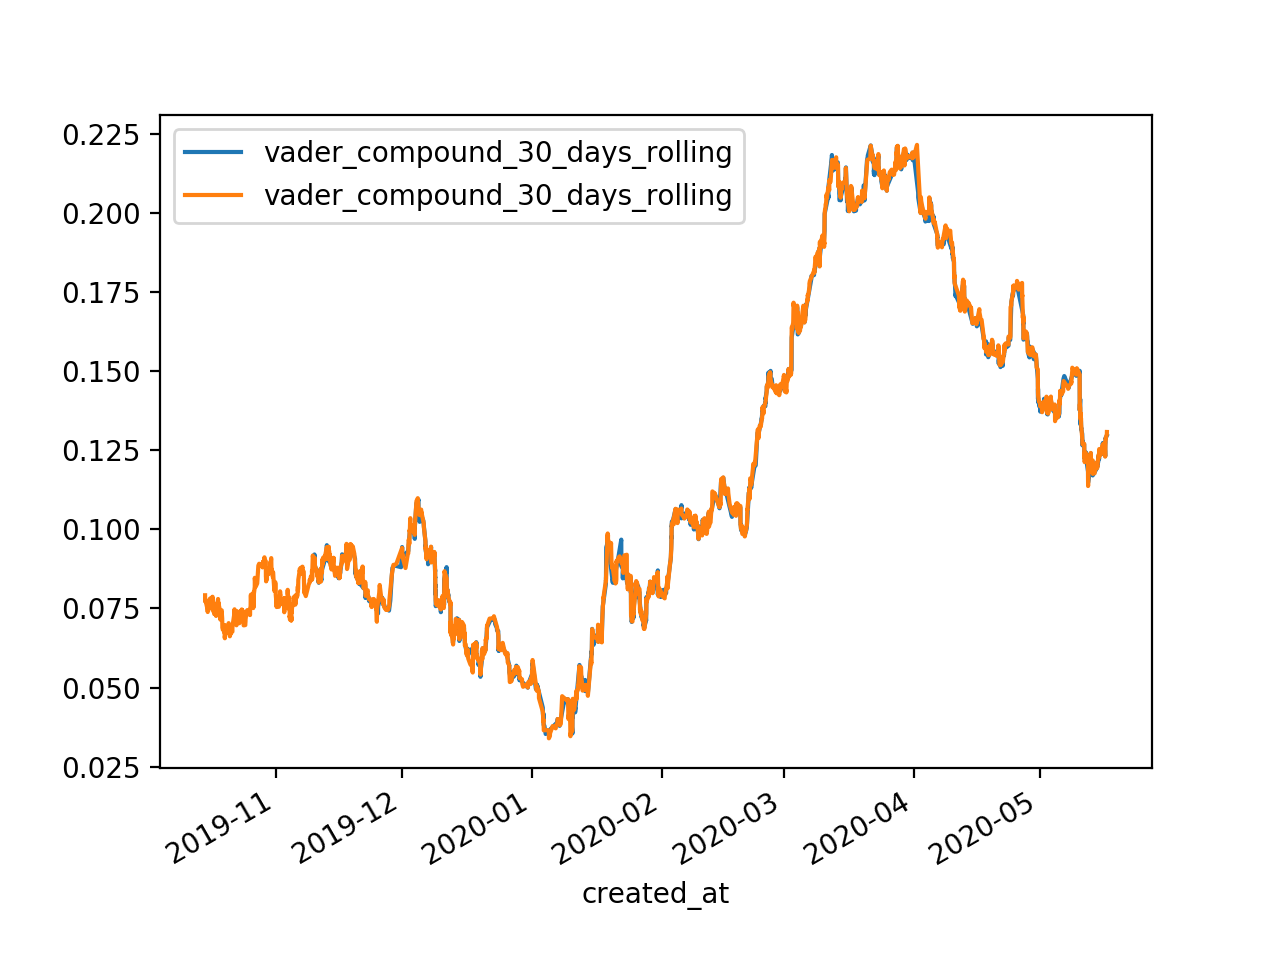

In [655]:
begin_gap = datetime.datetime(2019,1,1)
end_gap = datetime.datetime(2019,10,15)

retweets_before = retweets[retweets['created_at']<begin_gap]
originals_before = originals[originals['created_at']<begin_gap]

retweets_after = retweets[retweets['created_at']>end_gap]
originals_after = originals[originals['created_at']>end_gap]

fig, ax = plt.subplots(1, 1)
retweets_after.plot.line(x='created_at', y='vader_compound_30_days_rolling', ax=ax)
f=originals_after.plot.line(x='created_at',y='vader_compound_30_days_rolling', secondary_y=False, ax=ax)

<IPython.core.display.Javascript object>


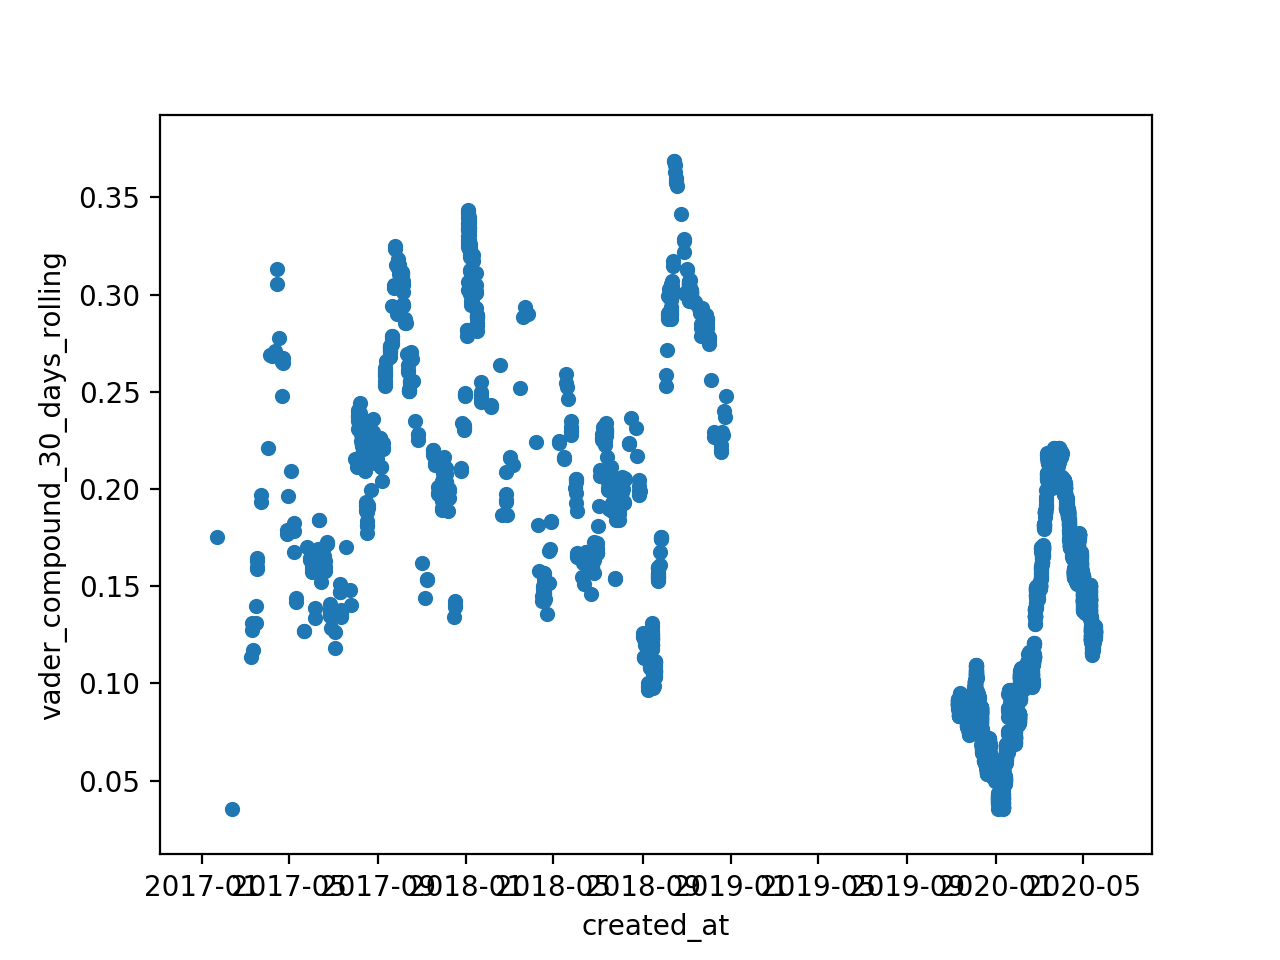

In [656]:
retweets.plot.scatter(x='created_at',y='vader_compound_30_days_rolling')

<IPython.core.display.Javascript object>


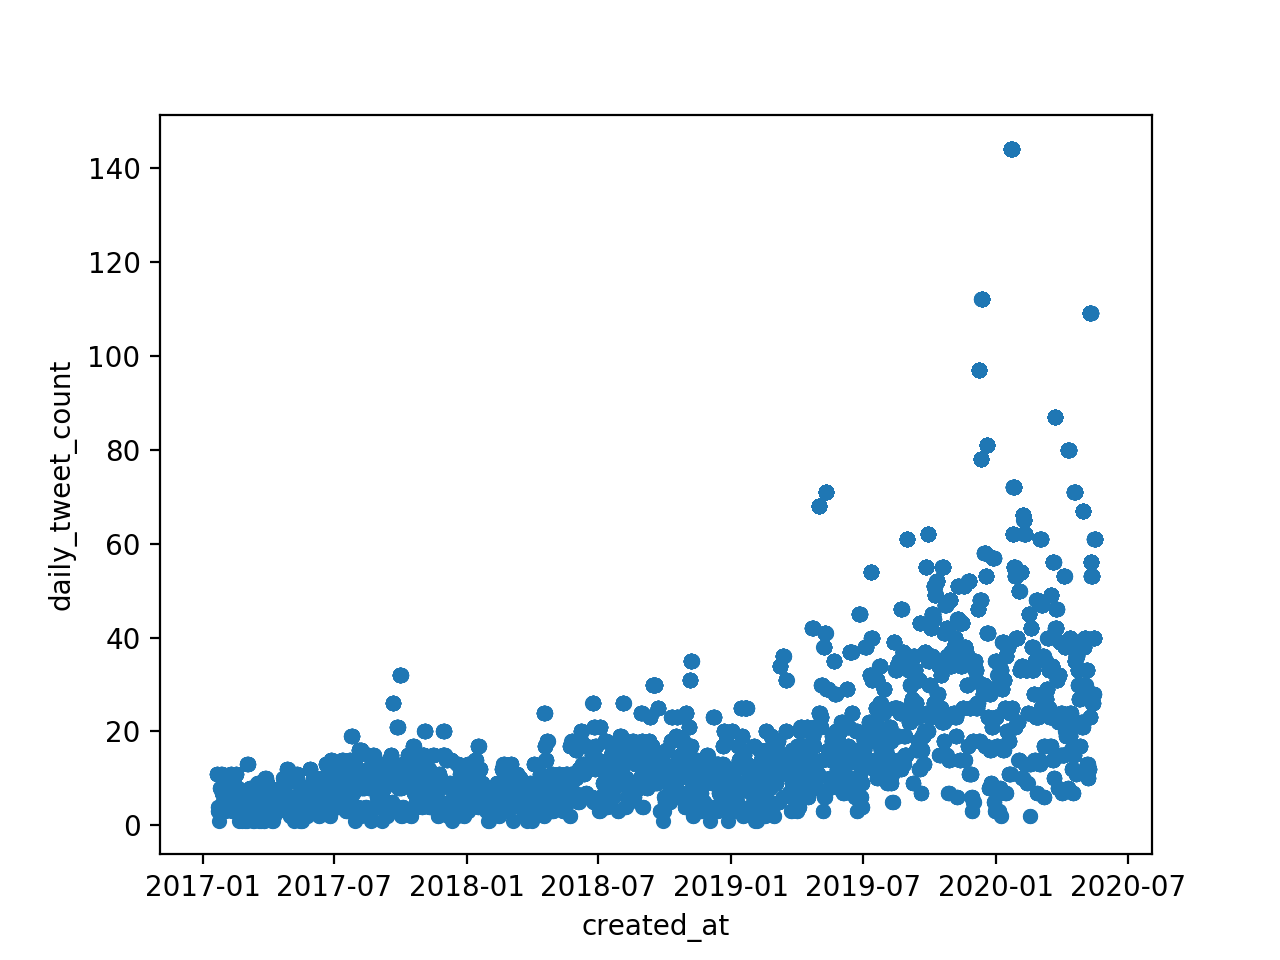

In [684]:
%matplotlib notebook
tweets.plot.scatter(x='created_at', y='daily_tweet_count')

In [669]:
tweets_a_lot = tweets[tweets['daily_tweet_count']>=20]
tweets_little = tweets[tweets['daily_tweet_count']<20]

<IPython.core.display.Javascript object>


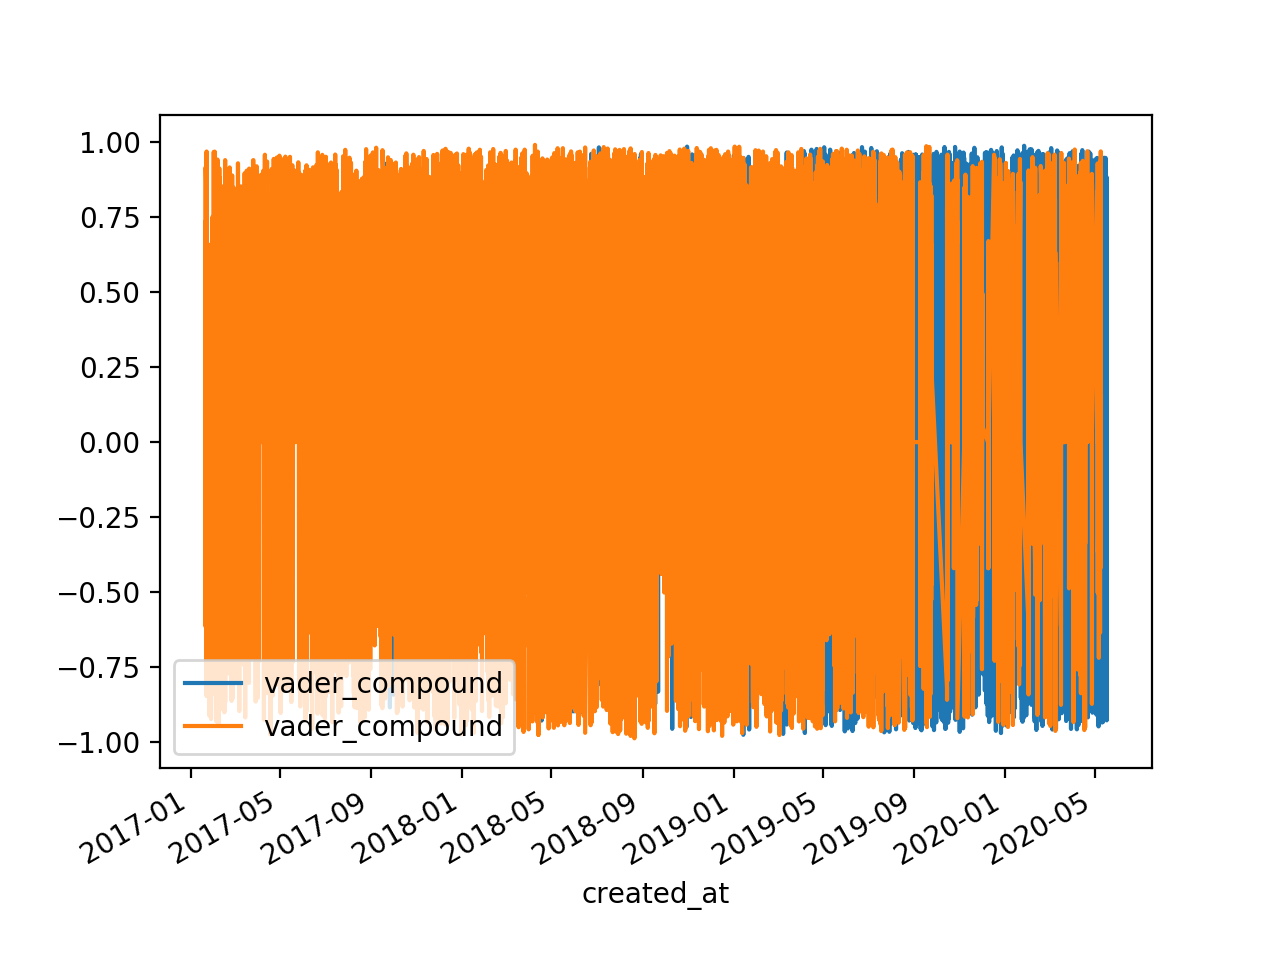

In [698]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1)
tweets_a_lot.plot(x='created_at', y='vader_compound', ax=ax)
f=tweets_little.plot(x='created_at', y='vader_compound', secondary_y=False, ax=ax)


In [699]:
tweet_storm = tweets_a_lot['vader_compound']
non_storm = tweets_little['vader_compound']

ttest,pval = stats.ttest_ind(tweet_storm, non_storm)
print(pval)

1.400688985343831e-16


In [700]:
tweet_storm.describe()

count    9776.000000
mean        0.120980
std         0.519855
min        -0.974700
25%        -0.271450
50%         0.000000
75%         0.585900
max         0.986900
Name: vader_compound, dtype: float64

In [701]:
non_storm.describe()

count    8245.000000
mean        0.189451
std         0.591008
min        -0.986400
25%        -0.294200
50%         0.312300
75%         0.732200
max         0.989900
Name: vader_compound, dtype: float64

<IPython.core.display.Javascript object>


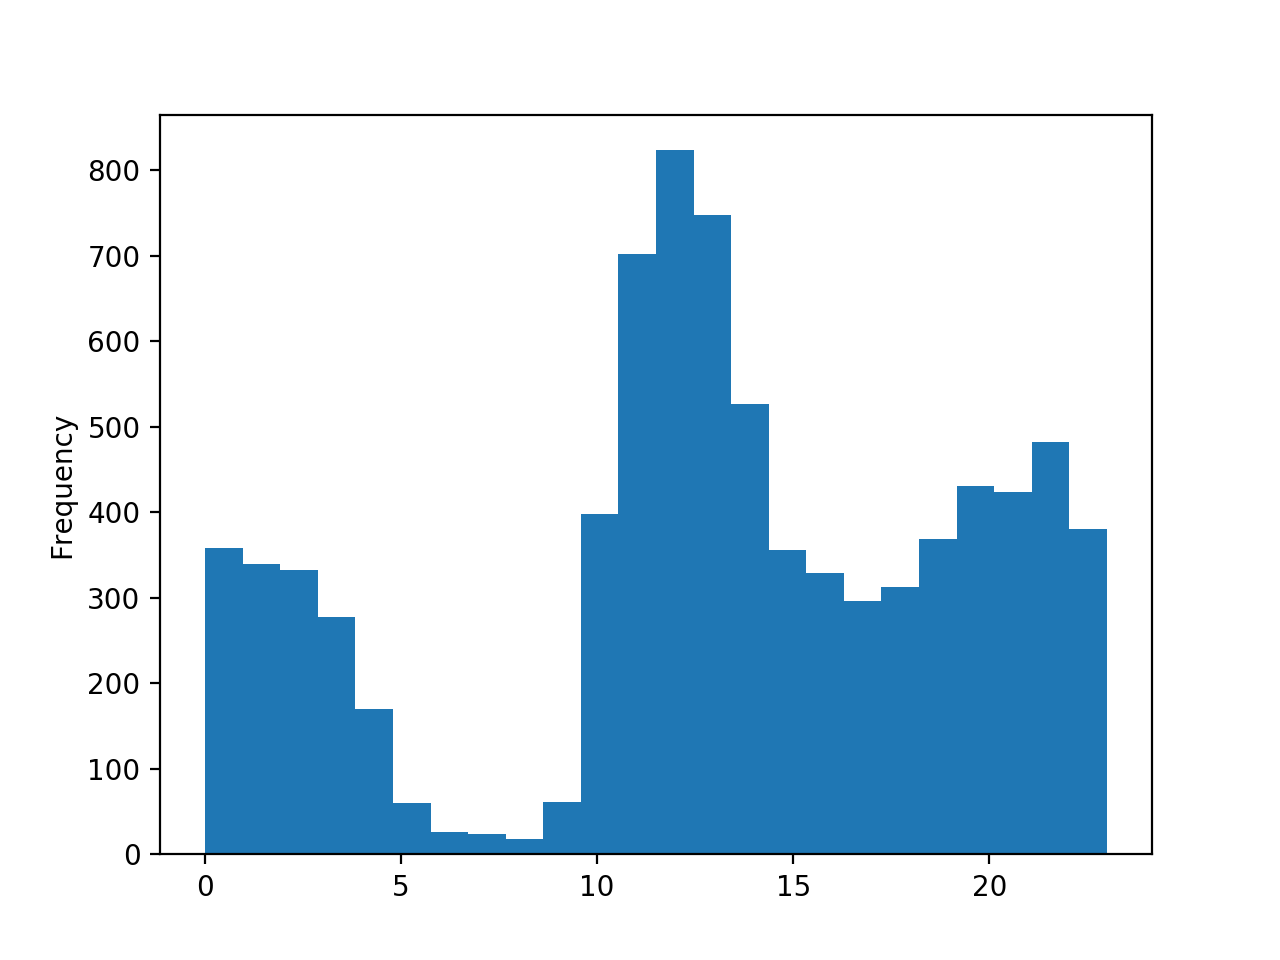

In [675]:
%matplotlib notebook
tweets_little['hour'].plot.hist(bins=24)

<IPython.core.display.Javascript object>


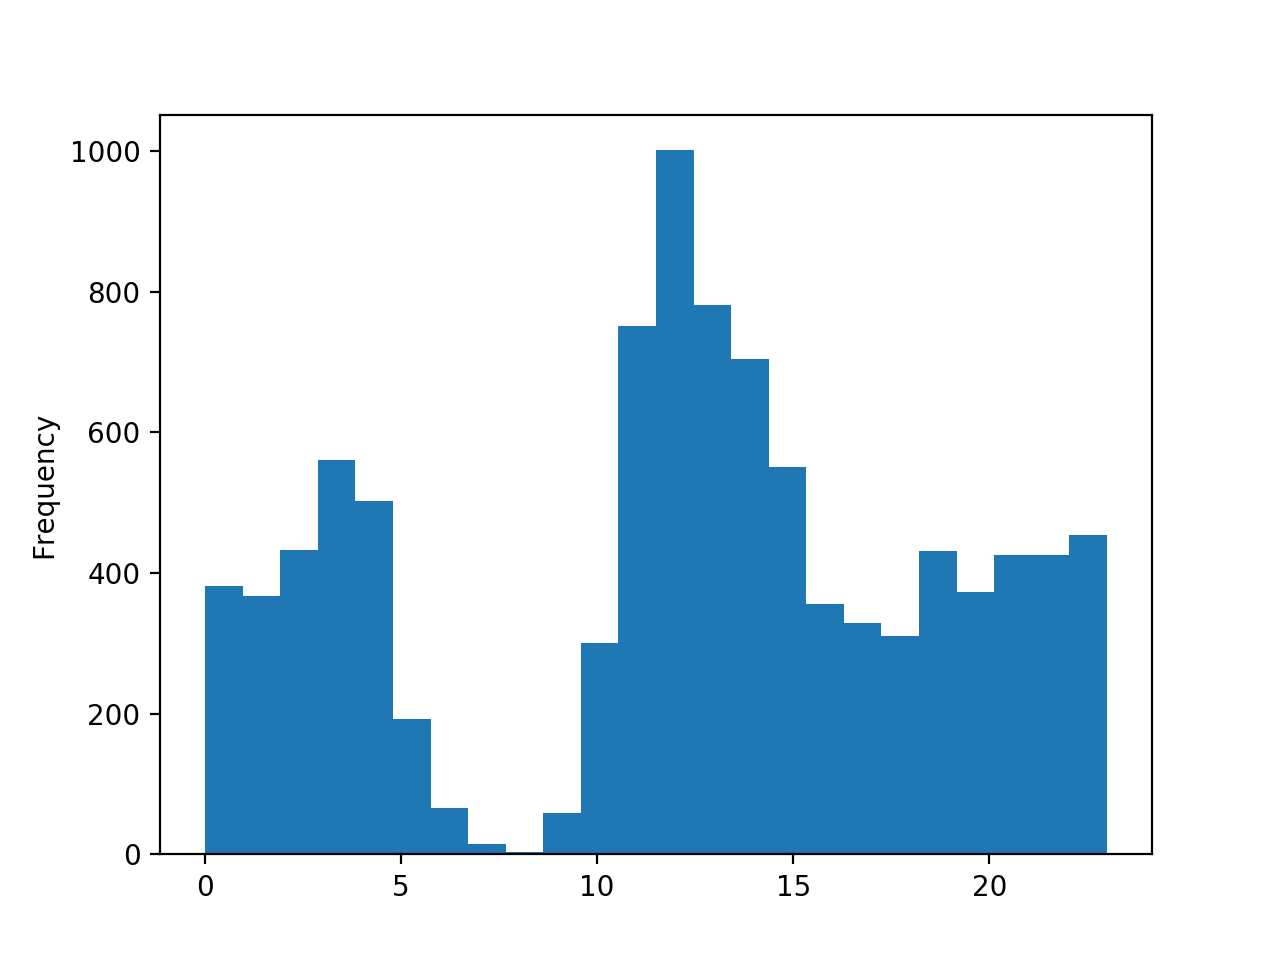

In [678]:
%matplotlib notebook
tweets_a_lot['hour'].plot.hist(bins=24)

<IPython.core.display.Javascript object>


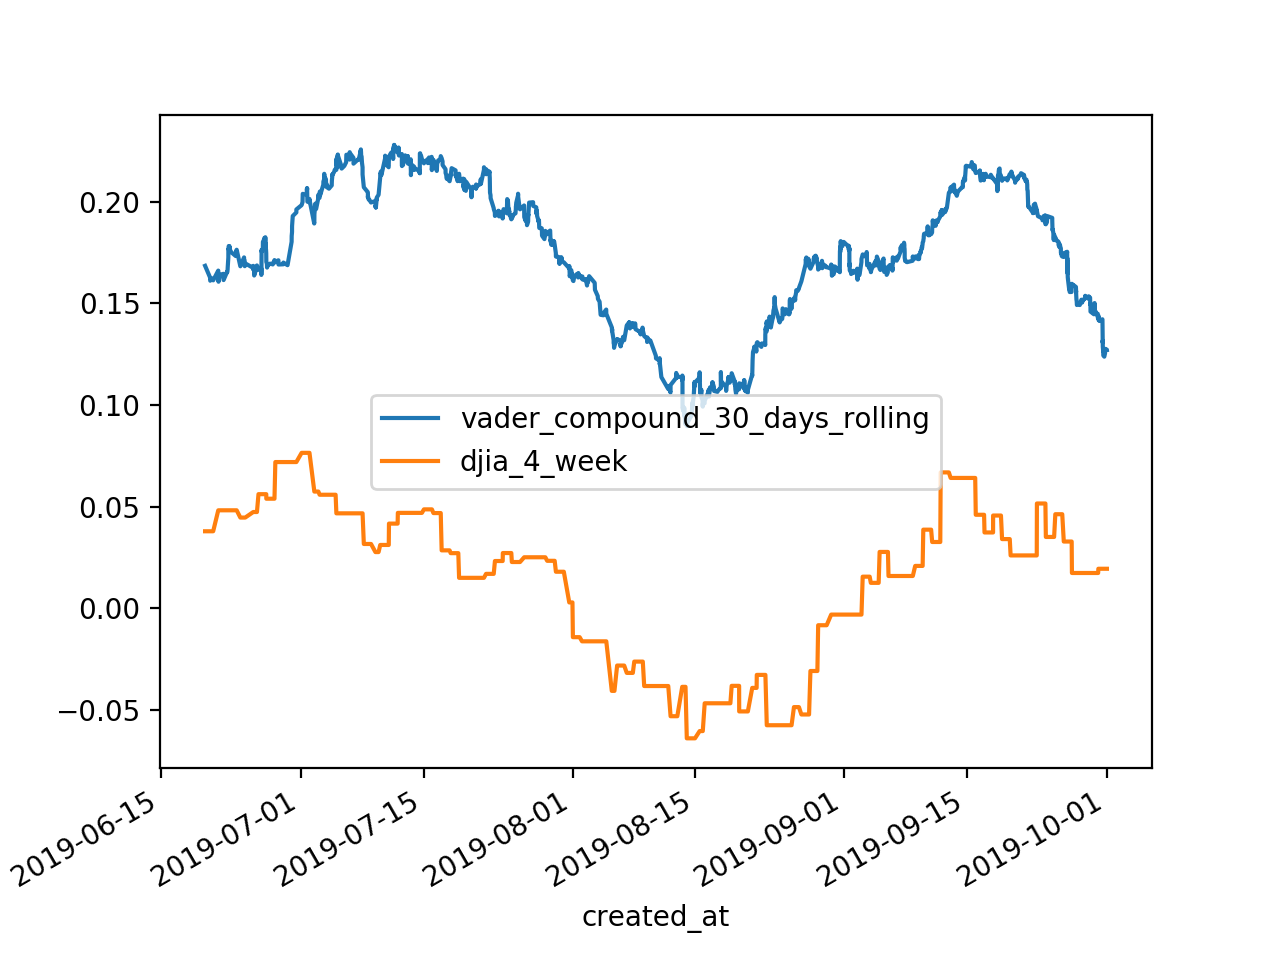

In [713]:
begin_v = datetime.datetime(2019,6,20)
end_v = datetime.datetime(2019,10,1)

v_tweets = tweets[(tweets['created_at']>begin_v) & (tweets['created_at']<end_v)]

v_tweets.plot(x='created_at', y=['vader_compound_30_days_rolling', 'djia_4_week'])

In [712]:
v_tweets[[
       'vader_compound_3_days_rolling',
       'vader_compound_7_days_rolling',
       'vader_compound_15_days_rolling',
       'vader_compound_30_days_rolling',
       'vader_compound_45_days_rolling',
       'vader_compound_60_days_rolling', 'djia', 'djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week', 'daily_tweet_count']].corr()[['djia', 'djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week', 'daily_tweet_count']]

djia  djia_1_day  djia_1_week  \
vader_compound_3_days_rolling  -0.033197   -0.065480     0.267458   
vader_compound_7_days_rolling   0.035050   -0.021762     0.367663   
vader_compound_15_days_rolling  0.344471    0.112208     0.515956   
vader_compound_30_days_rolling  0.794637    0.159950     0.379741   
vader_compound_45_days_rolling  0.767881    0.199712     0.014212   
vader_compound_60_days_rolling  0.400090    0.082043    -0.109414   
djia                            1.000000    0.378305     0.372508   
djia_1_day                      0.378305    1.000000     0.280915   
djia_1_week                     0.372508    0.280915     1.000000   
djia_2_week                     0.635815    0.335588     0.738633   
djia_3_week                     0.755969    0.221849     0.569763   
djia_4_week                     0.856922    0.309807     0.425888   
daily_tweet_count              -0.007470   -0.078362     0.129417   

                                djia_2_week  djia_3_week  djia_4_week  \
vader_compound_3_days_rolling      0.342152     0.162150     0.151269   
vader_compound_7_days_rolling      0.415334     0.323738     0.244803   
vader_compound_15_days_rolling     0.604169     0.542220     0.512037   
vader_compound_30_days_rolling     0.686323     0.772626     0.803035   
vader_compound_45_days_rolling     0.251021     0.442219     0.653422   
vader_compound_60_days_rolling     0.033125    -0.013545     0.116958   
djia                               0.635815     0.755969     0.856922   
djia_1_day                         0.335588     0.221849     0.309807   
djia_1_week                        0.738633     0.569763     0.425888   
djia_2_week                        1.000000     0.813399     0.710988   
djia_3_week                        0.813399     1.000000     0.868956   
djia_4_week                        0.710988     0.868956     1.000000   
daily_tweet_count                  0.027560    -0.056465    -0.023197   

                                daily_tweet_count  
vader_compound_3_days_rolling           -0.028914  
vader_compound_7_days_rolling           -0.093165  
vader_compound_15_days_rolling           0.032854  
vader_compound_30_days_rolling          -0.066693  
vader_compound_45_days_rolling          -0.063387  
vader_compound_60_days_rolling          -0.005766  
djia                                    -0.007470  
djia_1_day                              -0.078362  
djia_1_week                              0.129417  
djia_2_week                              0.027560  
djia_3_week                             -0.056465  
djia_4_week                             -0.023197  
daily_tweet_count                        1.000000

<IPython.core.display.Javascript object>


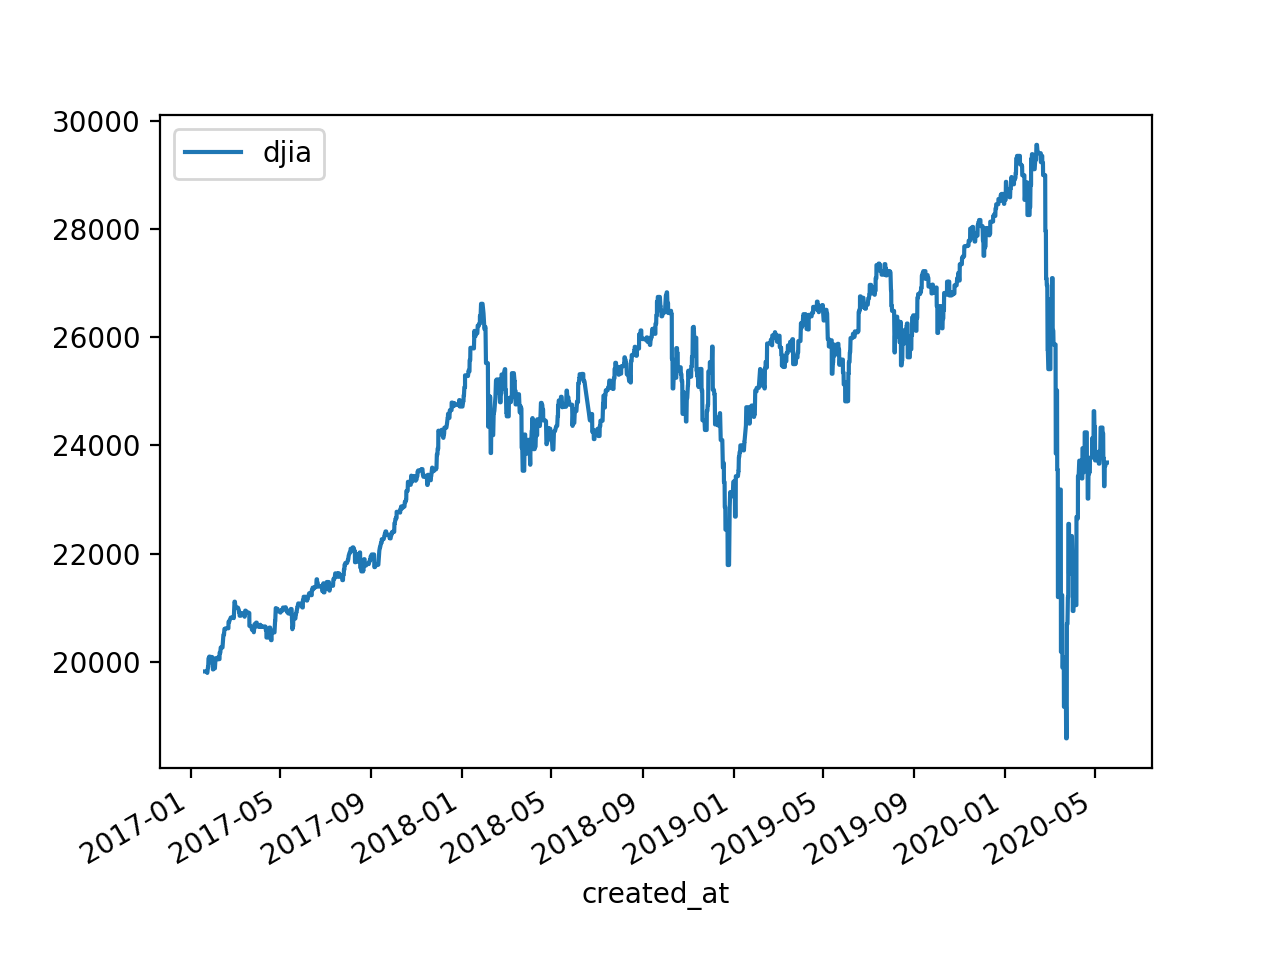

In [714]:
tweets.plot(x='created_at', y='djia')

<IPython.core.display.Javascript object>


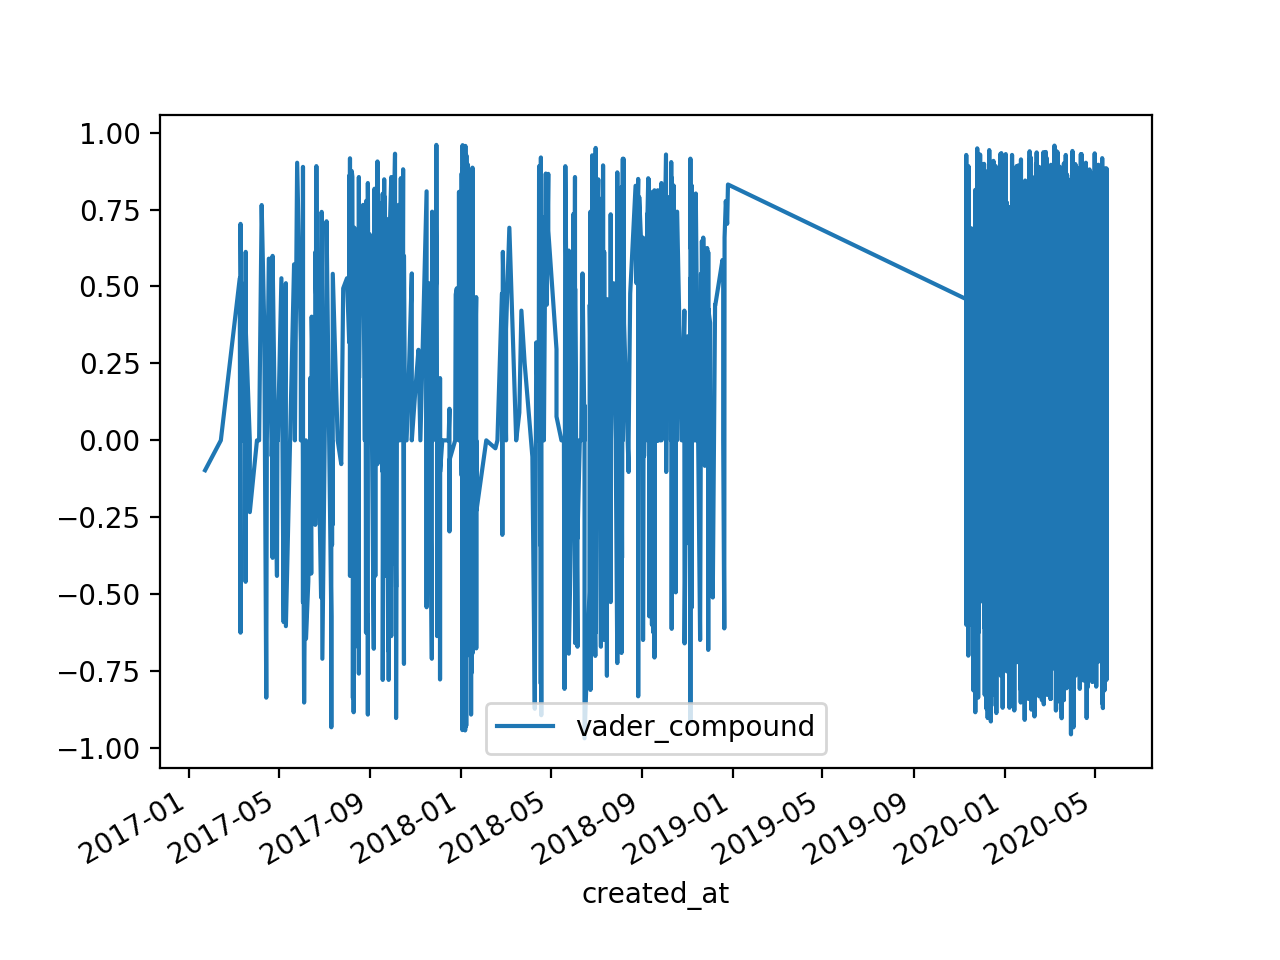

In [775]:
retweets.plot(x='created_at', y='vader_compound')

In [808]:
no_retweets_begin = datetime.datetime(2018,12,26)
no_retweets_end = datetime.datetime(2019,11,10)

no_retweets = tweets[(tweets['created_at']>no_retweets_begin) & (tweets['created_at']<no_retweets_end)]


In [809]:
tweets.loc[5989]

source                                                           Twitter for iPhone
text                              RT @Varneyco: STU: "Look what we have now! A g...
created_at                                                      2019-11-09 12:02:39
retweet_count                                                                  4576
favorite_count                                                                    0
is_retweet                                                                    False
id_str                                                          1193136819740794880
hour                                                                             12
clean_text                        RT  STU: "Look what we have now! A growing #ec...
polarity                                                                     0.4375
subjectivity                                                                   0.55
impeachment                                                                 

In [819]:
tweets['contains_RT']=tweets['clean_text'].str.contains(r'\b(RT)\b')
#tweets['contains_RT']=tweets['clean_text'].str.contains('RT')

In [820]:
tweets['contains_RT'].value_counts()

False    11878
True      6143
Name: contains_RT, dtype: int64

In [840]:
tweets['is_retweet'].value_counts()

False    13950
True      4071
Name: is_retweet, dtype: int64

In [824]:
tweets[tweets['is_retweet'] & tweets['contains_RT']].shape

(4013, 38)

In [825]:
tweets[~tweets['is_retweet'] & ~tweets['contains_RT']].shape

(11820, 38)

In [898]:
tweets[~tweets['is_retweet'] & tweets['contains_RT']].tail(25)

source  \
11918  Twitter for iPhone   
11919  Twitter for iPhone   
11920  Twitter for iPhone   
11928  Twitter for iPhone   
11929  Twitter for iPhone   
11930  Twitter for iPhone   
11931  Twitter for iPhone   
11932  Twitter for iPhone   
11965  Twitter for iPhone   
11966  Twitter for iPhone   
11977  Twitter for iPhone   
11985  Twitter for iPhone   
11986  Twitter for iPhone   
11987  Twitter for iPhone   
11988  Twitter for iPhone   
11989  Twitter for iPhone   
11990  Twitter for iPhone   
12014  Twitter for iPhone   
12015  Twitter for iPhone   
12062  Twitter for iPhone   
12063  Twitter for iPhone   
12064  Twitter for iPhone   
12065  Twitter for iPhone   
12070  Twitter for iPhone   
16921  Twitter for iPhone   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         text  \
11918                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           RT @DonaldJTrumpJr: ‘Angel mom’ demands Trump’s wall ‘we’ve become collateral damage’ https://t.co/FoUPO11tmM   
11919                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              RT @DonaldJTrumpJr: Silence of the Moms: Media Refuse to Discuss Angel Families https://t.co/AoVIquJge2 via @BreitbartNews   
11920                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               RT @WhiteHouse: President Trump Delivers Remarks at the American Farm Bureau Federation's 100th Annual Convention https://t.co/tMWj5zj3K0   
11928                                                                                                                                                                                                                                                                                                                       

In [836]:
tweets[tweets['is_retweet'] & ~tweets['contains_RT']].head()

source  \
15507  Twitter for iPhone   
15508  Twitter for iPhone   
15509  Twitter for iPhone   
15510  Twitter for iPhone   
15511  Twitter for iPhone   

                                                                                                                                                                                                                                                                                                              text  \
15507                         Thanks to all of the Republican and Democratic lawmakers for today’s very productive meeting on immigration reform. There was strong agreement to negotiate a bill that deals with border security chain migration lottery and DACA. https://t.co/SdqAQ3aL3z https://t.co/8DYHZHspAy   
15508     It was my great honor to sign H.R. 267 the “Martin Luther King Jr. National Historical Park Act” which redesignates the Martin Luther King Junior National Historic Site in the State of Georgia as the Martin Luther King Jr. National Historical Park. https://t.co/Qe0b6HBFTY https://t.co/QTgaqTawPT   
15509     On behalf of the American people THANK YOU to our incredible law enforcement officers. As President of the United States - I will fight for you and I will never ever let you down. Now more than ever we must support the men and women in blue! #LawEnforcementAppreciationDay https://t.co/Qb4uxB4JRm   
15510                                                                                                                        We are fighting for our farmers for our country and for our GREAT AMERICAN FLAG. We want our flag respected - and we want our NATIONAL ANTHEM respected also! https://t.co/16eOLXg6Fi   
15511  In every decision we make we are honoring America’s PROUD FARMING LEGACY. Years of crushing taxes crippling regs & corrupt politics left our communities hurting our economy stagnant & millions of hardworking Americans COMPLETELY FORGOTTEN. But they are not forgotten ANYMORE! https://t.co/MdYS7xnukQ   

               created_at  retweet_count  favorite_count  is_retweet  \
15507 2018-01-09 22:51:50          11718           58068        True   
15508 2018-01-09 20:17:17          17249           73554        True   
15509 2018-01-09 17:11:23          26793          112613        True   
15510 2018-01-08 23:19:47          22044          104968        True   
15511 2018-01-08 22:59:37          17769           81027        True   

                   id_str  hour  \
15507  950862709599465472    22   
15508  950823813868122112    20   
15509  950777029816963072    17   
15510  950507353094356993    23   
15511  950502279785959425    22   

                                                                                                                                                                                                                                                                                 clean_text  \
15507                                                Thanks to all of the Republican and Democratic lawmakers for today’s very productive meeting on immigration reform. There was strong agreement to negotiate a bill that deals with border security chain migration lottery and DACA.     
15508                            It was my great honor to sign H.R. 267 the “Martin Luther King Jr. National Historical Park Act” which redesignates the Martin Luther King Junior National Historic Site in the State of Georgia as the Martin Luther King Jr. National Historical Park.     
15509     On behalf of the American people THANK YOU to our incredible law enforcement officers. As President of the United States - I will fight for you and I will never ever let you down. Now more than ever we must support the men and women in blue! #LawEnforcementAppreciationDay    
15510                                                                                                                        We are fighting for our farmers for our country and for our GREAT 

In [835]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
tweets[16921:16922]

source  \
16921  Twitter for iPhone   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         text  \
16921  One of the things that has been lost in the politics of this situation is that the Russians collected and spread negative information.....,07-27-2017 13:35:35,13164,57728,false,890566339462672385\nTwitter for iPhone,RT @townhallcom: ABC NBC And CBS Pretty Much Bury IT Scandal Engulfing Debbie Wasserman Schultz's Office https://t.co/PjbZ2TGIKb,07-27-2017 12:49:41,25716,0,true,890554786755555329\nTwitter for iPhone,Come on Republican Senators you can do it on Healthcare. After 7 years this is your chance to shine! Don't let the American people down!,07-27-2017 11:24:52,21456,93516,false,890533442135502849\nTwitter for iPhone,Wow the Failing @nytimes said about @foxandfriends ....the most powerful T.V. show in America."   

               created_at  retweet_count  favorite_count  is_retweet  \
16921 2017-07-27 10:48:53          11826           55479       False   

                   id_str  hour  \
16921  890524387773997056    10   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              clean_text  \
16921  One of the things that has been lost in the politics of this situation is that the Russians collected and spread negative information.....,07-27-2017 13:35:35,13164,57728,false,890566339462672385\nTwitter for iPhone,RT  ABC NBC And CBS Pretty Much Bury IT Scandal Engulfing Debbie Wasserman Schultz's Office  12:49:41,25716,0,true,890554786755555329\nTwitter for iPhone,Come on Republican Senators you can do it on Healthcare. After 7 years this is your chance to shine! Don't let the American people down!,07-27-2017 11:24:52,21456,93516,false,890533442135502849\nTwitter for iPhone,Wow the Failing  said about  ....the most powerful T.V. show in America."   

       polarity  subjectivity  impeachment  \
16921  0.166667      0.516667        False   

                                                                 vader  \
16921  {'neg': 0.132, 'neu': 0.783, 'pos': 0.085, 'compound': -0.6695}   

       vader_neg  vader_neu  vader_pos  vader_compound  \
16921      0.132      0.783      0.085         -0.6695   

       polarity_3_days_rolling  vader_compound_3_days_rolling  \
16921                 0.092927                       0.139938   

       polarity_7_days_rolling  vader_compound_7_days_rolling  \
16921                 0.113036                       0.135526   

       polarity_15_days_rolling  vader_compound_15_days_rolling  \
16921                  0.154461                        0.211552   

       polarity_30_days_rolling  vader_compound_30_days_rolling  \
16921                  0.129946                        0.159209   

       polarity_45_days_rolling  vader_co

In [838]:
tweets[tweets['contains_RT']].describe()

retweet_count  favorite_count        id_str         hour     polarity  \
count    6143.000000     6143.000000  6.143000e+03  6143.000000  6143.000000   
mean    11871.031255        9.031255  1.171567e+18    11.691519     0.094551   
std     11019.459441      707.845323  8.718275e+16     6.802518     0.295625   
min         3.000000        0.000000  8.229556e+17     0.000000    -1.000000   
25%      5983.000000        0.000000  1.146947e+18     4.000000     0.000000   
50%      8950.000000        0.000000  1.199068e+18    12.000000     0.000000   
75%     13965.000000        0.000000  1.226540e+18    17.000000     0.200000   
max    210171.000000    55479.000000  1.261786e+18    23.000000     1.000000   

       subjectivity    vader_neg    vader_neu    vader_pos  vader_compound  \
count   6143.000000  6143.000000  6143.000000  6143.000000     6143.000000   
mean       0.341003     0.068213     0.821388     0.110396        0.082557   
std        0.321498     0.106883     0.157563     0.142260        0.447836   
min        0.000000     0.000000     0.129000     0.000000       -0.968100   
25%        0.000000     0.000000     0.718000     0.000000       -0.200300   
50%        0.316667     0.000000     0.837000     0.055000        0.000000   
75%        0.566667     0.126500     1.000000     0.185000        0.440400   
max        1.000000     0.672000     1.000000     0.871000        0.979600   

       polarity_3_days_rolling  vader_compound_3_days_rolling  \
count              6143.000000                    6143.000000   
mean                  0.120750                       0.134009   
std                   0.058602                       0.108467   
min                  -0.049622                      -0.234113   
25%                   0.081275                       0.057983   
50%                   0.110246                       0.121599   
75%                   0.157535                       0.199391   
max                   0.406001                       0.728238   

       polarity_7_days_rolling  vader_compound_7_days_rolling  \
count              6143.000000                    6143.000000   
mean                  0.124372                       0.136970   
std                   0.043903                       0.087490   
min                   0.002201                      -0.052971   
25%                   0.091728                       0.071495   
50%                   0.118746                       0.126125   
75%                   0.152105                       0.190090   
max                   0.377154                       0.560537   

       polarity_15_days_rolling  vader_compound_15_days_rolling  \
count               6143.000000                     6143.000000   
mean                   0.123848                        0.135743   
std                    0.034332                        0.071785   
min                    0.050668                       -0.032821   
25%                    0.102198                        0.082201   
50%                    0.119576                        0.120541   
75%                    0.141253                        0.182780   
max                    0.277706                        0.480434   

       polarity_30_days_rolling  vader_compound_30_days_rolling  \
count               6143.000000                     6143.000000   
mean                   0.122900                        0.132771   
std                    0.028368                        0.061160   
min                    0.068197                        0.030742   
25%                    0.101265                        0.083122   
50%                    0.118641                        0.119785   
75%                    0.138159                        0.173679   
max                    0.218326                        0.368960   

       polarity_45_days_rolling  vader_compound_45_days_rolling  \
count               6143.000000                     6143.000000   
mean                   0.122793                        0.132075   
st

In [839]:
tweets[~tweets['contains_RT']].describe()

retweet_count  favorite_count        id_str          hour  \
count   11878.000000    11878.000000  1.187800e+04  11878.000000   
mean    20671.996380    88909.645732  1.085397e+18     13.103890   
std     12850.735861    52491.389232  1.211434e+17      6.600457   
min         0.000000        0.000000  8.224214e+17      0.000000   
25%     13474.250000    58803.750000  9.956517e+17     11.000000   
50%     18422.000000    79929.500000  1.111264e+18     13.000000   
75%     24969.000000   107053.250000  1.185586e+18     18.000000   
max    369530.000000   879647.000000  1.261793e+18     23.000000   

           polarity  subjectivity     vader_neg     vader_neu     vader_pos  \
count  11878.000000  11878.000000  11878.000000  11878.000000  11878.000000   
mean       0.154183      0.458645      0.087624      0.685299      0.185740   
std        0.342708      0.283687      0.116388      0.225074      0.188241   
min       -1.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.283333      0.000000      0.606000      0.025000   
50%        0.075000      0.500000      0.047000      0.721000      0.142000   
75%        0.335170      0.655804      0.147000      0.821000      0.276000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       vader_compound  polarity_3_days_rolling  vader_compound_3_days_rolling  \
count    11878.000000             11878.000000                   11878.000000   
mean         0.188380                 0.140528                       0.162567   
std          0.599251                 0.072876                       0.144324   
min         -0.986400                -0.148393                      -0.432373   
25%         -0.325300                 0.089997                       0.063270   
50%          0.336700                 0.136238                       0.150388   
75%          0.735100                 0.183874                       0.250685   
max          0.989900                 0.503022                       0.816233   

       polarity_7_days_rolling  vader_compound_7_days_rolling  \
count             11878.000000                   11878.000000   
mean                  0.141074                       0.162525   
std                   0.051851                       0.105204   
min                  -0.033535                      -0.178748   
25%                   0.102889                       0.085179   
50%                   0.137138                       0.151177   
75%                   0.173924                       0.230678   
max                   0.397607                       0.577204   

       polarity_15_days_rolling  vader_compound_15_days_rolling  \
count              11878.000000                    11878.000000   
mean                   0.140422                        0.163049   
std                    0.040358                        0.084443   
min                    0.000000                       -0.069479   
25%                    0.111042                        0.094538   
50%                    0.138146                        0.153624   
75%                    0.166804                        0.217904   
max                    0.280460                        0.488585   

       polarity_30_days_rolling  vader_compound_30_days_rolling  \
count              11878.000000                    11878.000000   
mean                   0.140917                        0.163771   
std                    0.033820                        0.072257   
min                    0.000000                       -0.021955   
25%                    0.115246                        0.103365   
50%                    0.142402                        0.162716   
75%                    0.166024                        0.212457   
max                    0.220315                        0.373840   

       polarity_45_days_rolling  vader_compound_45_days_rolling  \
count              11878.000000                    11878.000000   
mean                   0

<IPython.core.display.Javascript object>


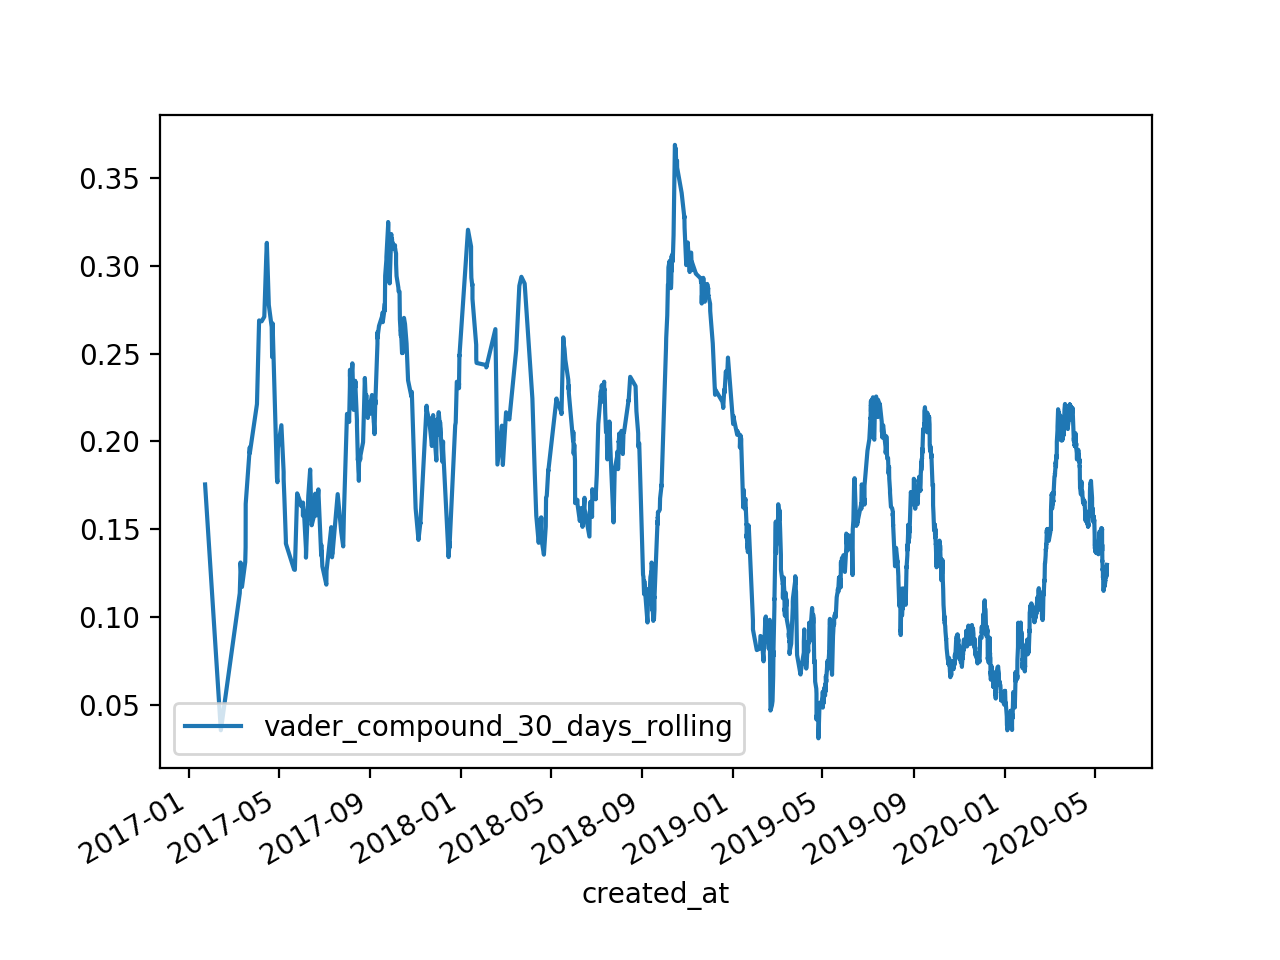

In [841]:
tweets[tweets['contains_RT']].plot(x='created_at', y = 'vader_compound_30_days_rolling')

In [874]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)

#kmeans.fit(tweets[['hour', 'vader_compound', 'contains_RT', 'daily_tweet_count']])

#tweets['label']=kmeans.labels_
tweets['clusters'] = kmeans.fit_predict(tweets[['hour', 'vader_compound', 'contains_RT', 'daily_tweet_count']])


<IPython.core.display.Javascript object>


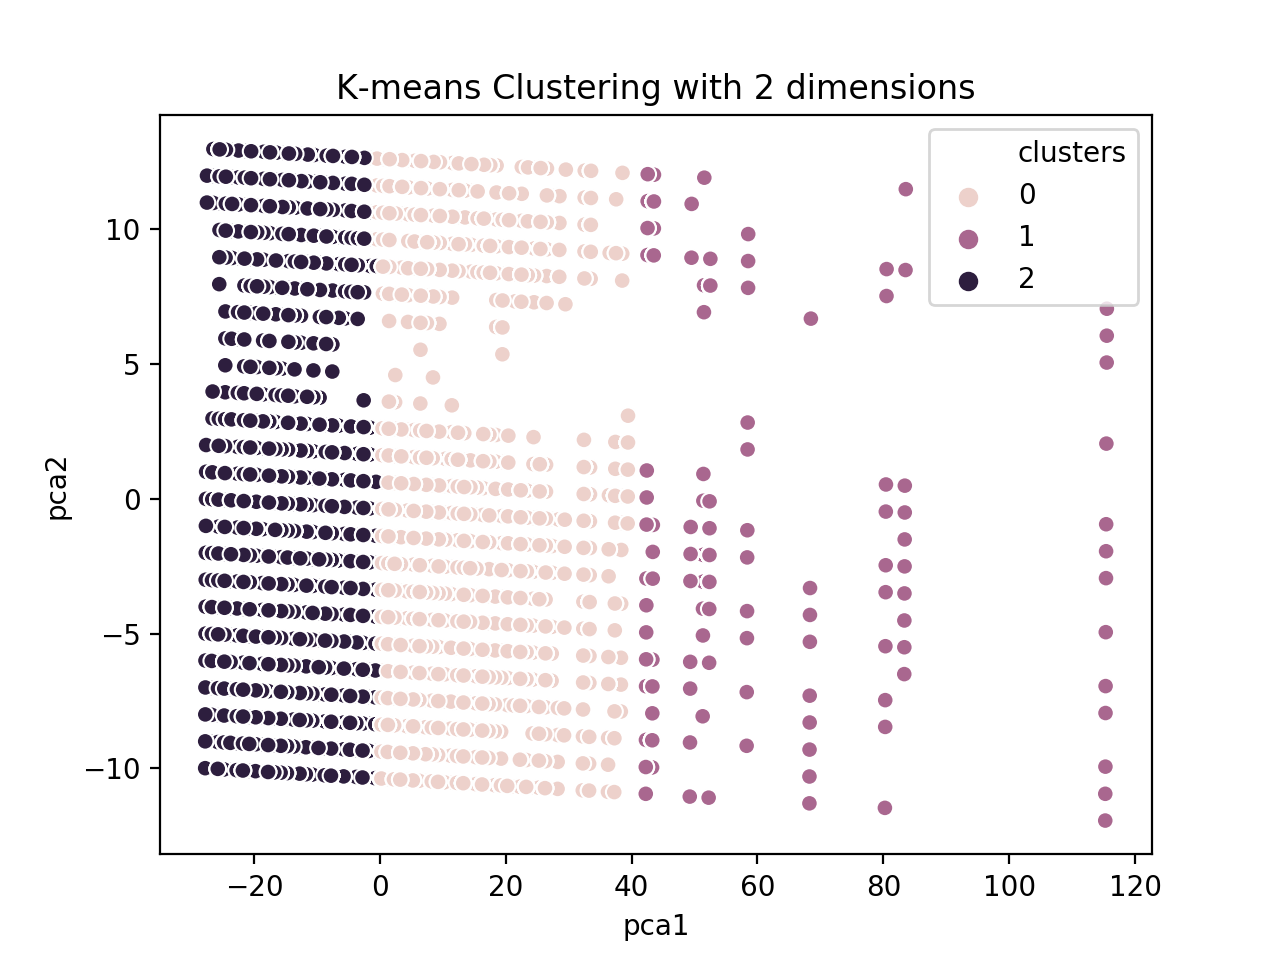

In [884]:
%matplotlib notebook

import seaborn as sns
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(tweets[['hour', 'vader_compound', 'contains_RT', 'daily_tweet_count']])
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=tweets['clusters'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()


In [861]:
tweets.columns

Index(['source', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'is_retweet', 'id_str', 'hour', 'clean_text', 'polarity',
       'subjectivity', 'impeachment', 'vader', 'vader_neg', 'vader_neu',
       'vader_pos', 'vader_compound', 'polarity_3_days_rolling',
       'vader_compound_3_days_rolling', 'polarity_7_days_rolling',
       'vader_compound_7_days_rolling', 'polarity_15_days_rolling',
       'vader_compound_15_days_rolling', 'polarity_30_days_rolling',
       'vader_compound_30_days_rolling', 'polarity_45_days_rolling',
       'vader_compound_45_days_rolling', 'polarity_60_days_rolling',
       'vader_compound_60_days_rolling', 'djia', 'djia_1_day', 'djia_1_week',
       'djia_2_week', 'djia_3_week', 'djia_4_week', 'daily_tweet_count',
       'date', 'contains_RT', 'label', 'clusters'],
      dtype='object')

In [876]:
tweets['clusters'].value_counts()

2    10752
0     6267
1     1002
Name: clusters, dtype: int64

In [885]:
tweets[tweets['clusters']==0][['hour', 'vader_compound', 'contains_RT', 'daily_tweet_count']].describe()

hour  vader_compound  daily_tweet_count
count  6267.000000     6267.000000        6267.000000
mean     11.970002        0.128506          42.453965
std       6.804417        0.509183          10.528892
min       0.000000       -0.971800          28.000000
25%       5.000000       -0.224400          34.000000
50%      13.000000        0.000000          39.000000
75%      17.000000        0.578450          51.000000
max      23.000000        0.986900          68.000000

In [886]:
tweets[tweets['clusters']==1][['hour', 'vader_compound', 'contains_RT', 'daily_tweet_count']].describe()

hour  vader_compound  daily_tweet_count
count  1002.000000     1002.000000        1002.000000
mean     12.974052        0.031809          96.257485
std       5.727872        0.457205          24.074177
min       0.000000       -0.961400          71.000000
25%      11.000000       -0.318200          78.000000
50%      13.000000        0.000000          87.000000
75%      17.000000        0.419900         112.000000
max      23.000000        0.964800         144.000000

In [887]:
tweets[tweets['clusters']==2][['hour', 'vader_compound', 'contains_RT', 'daily_tweet_count']].describe()

hour  vader_compound  daily_tweet_count
count  10752.000000    10752.000000       10752.000000
mean      12.969959        0.177409          14.224516
std        6.700464        0.585339           6.487168
min        0.000000       -0.986400           1.000000
25%       10.000000       -0.296000           9.000000
50%       13.000000        0.252000          14.000000
75%       19.000000        0.717100          19.000000
max       23.000000        0.989900          28.000000

<IPython.core.display.Javascript object>


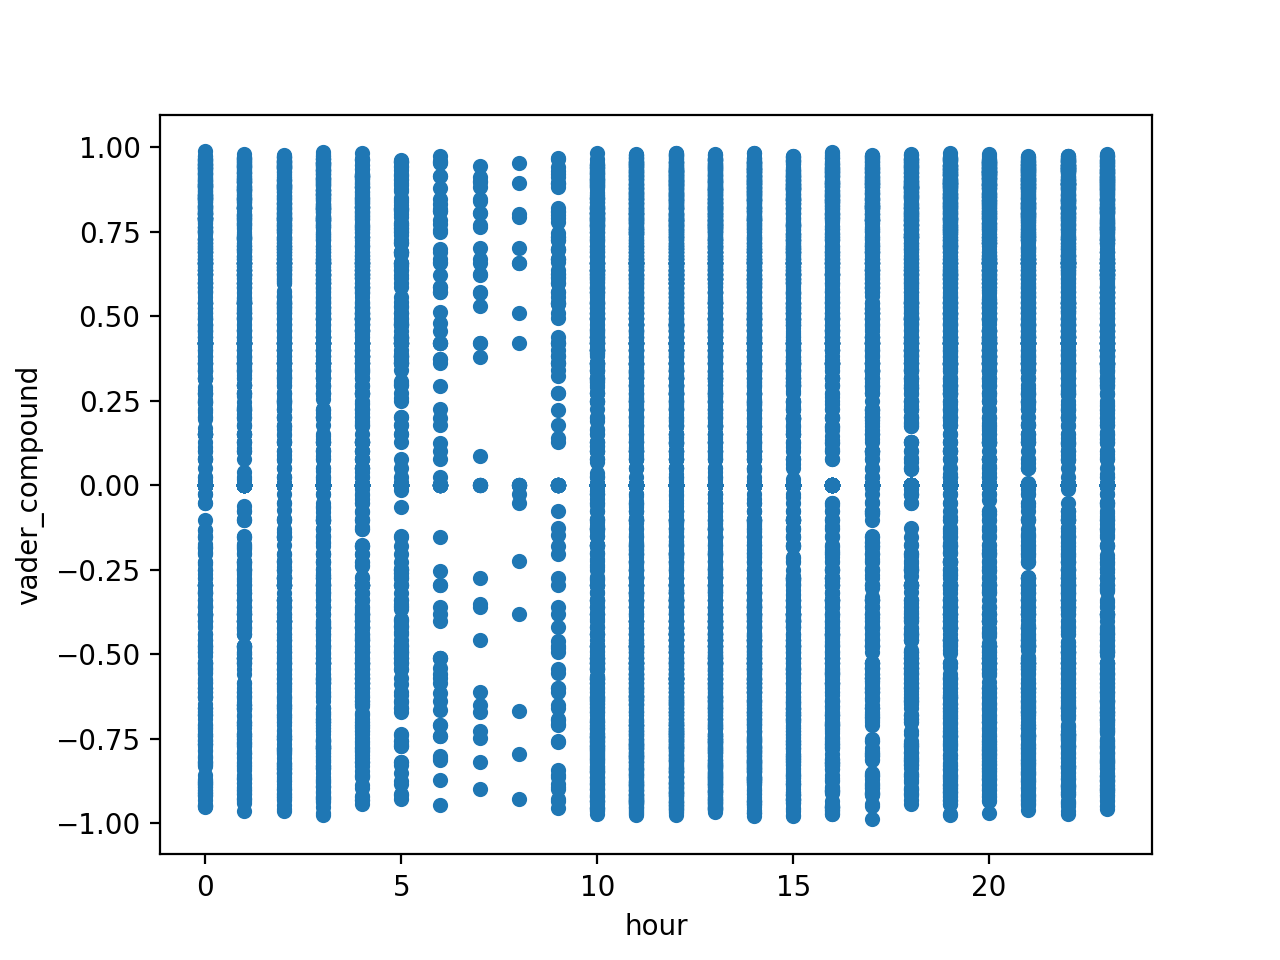

In [889]:
tweets.plot.scatter(x='hour', y='vader_compound')

<IPython.core.display.Javascript object>


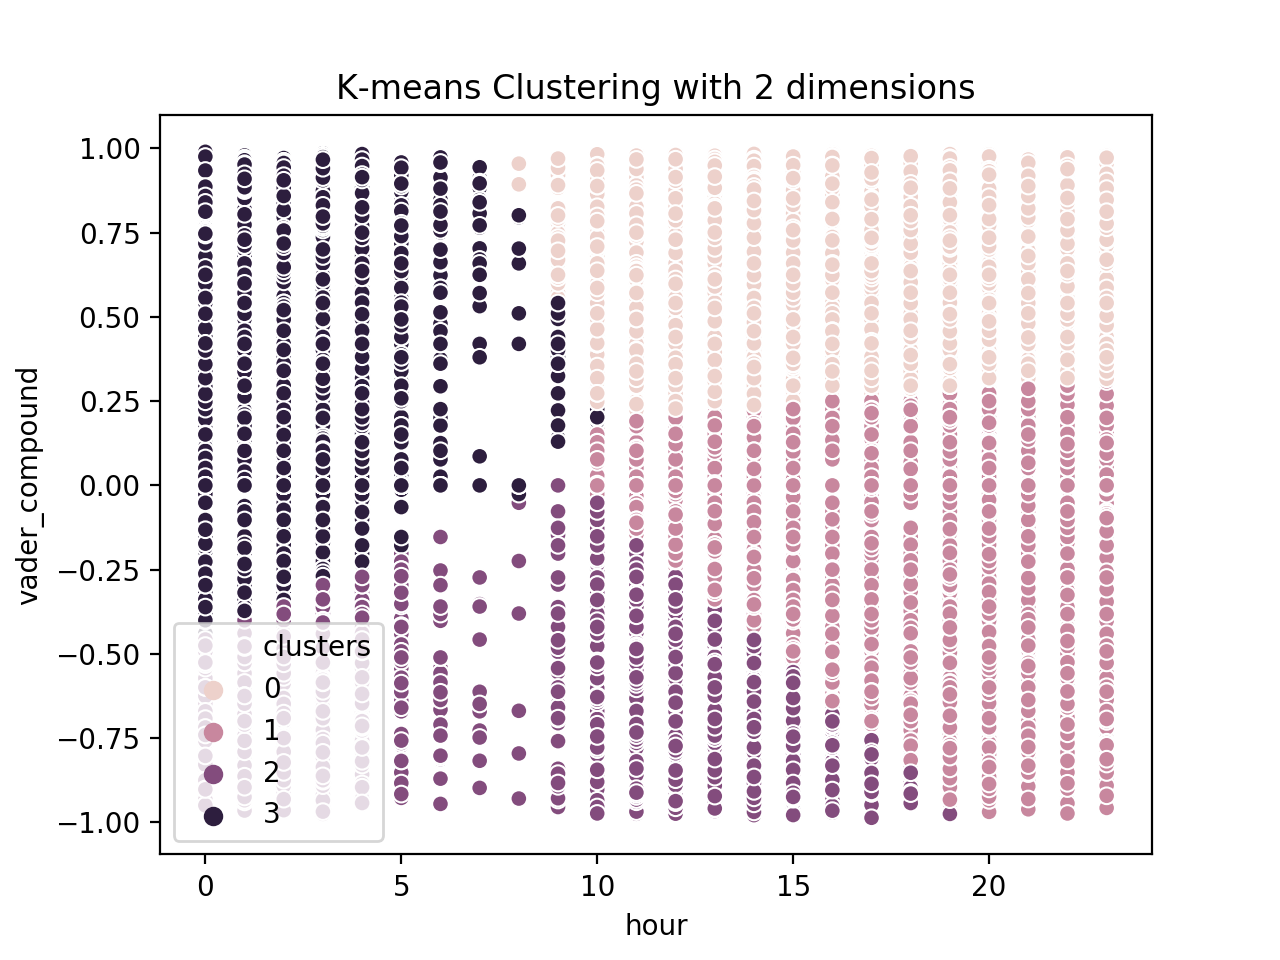

In [896]:
kmeans = KMeans(n_clusters=4)

tweets['hour_norm'] = (tweets['hour']-tweets['hour'].mean())/tweets['hour'].std()
tweets['vader_compound_norm'] = (tweets['vader_compound']-tweets['vader_compound'].mean())/tweets['vader_compound'].std()



tweets['clusters'] = kmeans.fit_predict(tweets[['hour_norm', 'vader_compound_norm']])

%matplotlib notebook
sns.scatterplot(x=tweets["hour"], y=tweets["vader_compound"], hue=tweets['clusters'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()



<IPython.core.display.Javascript object>


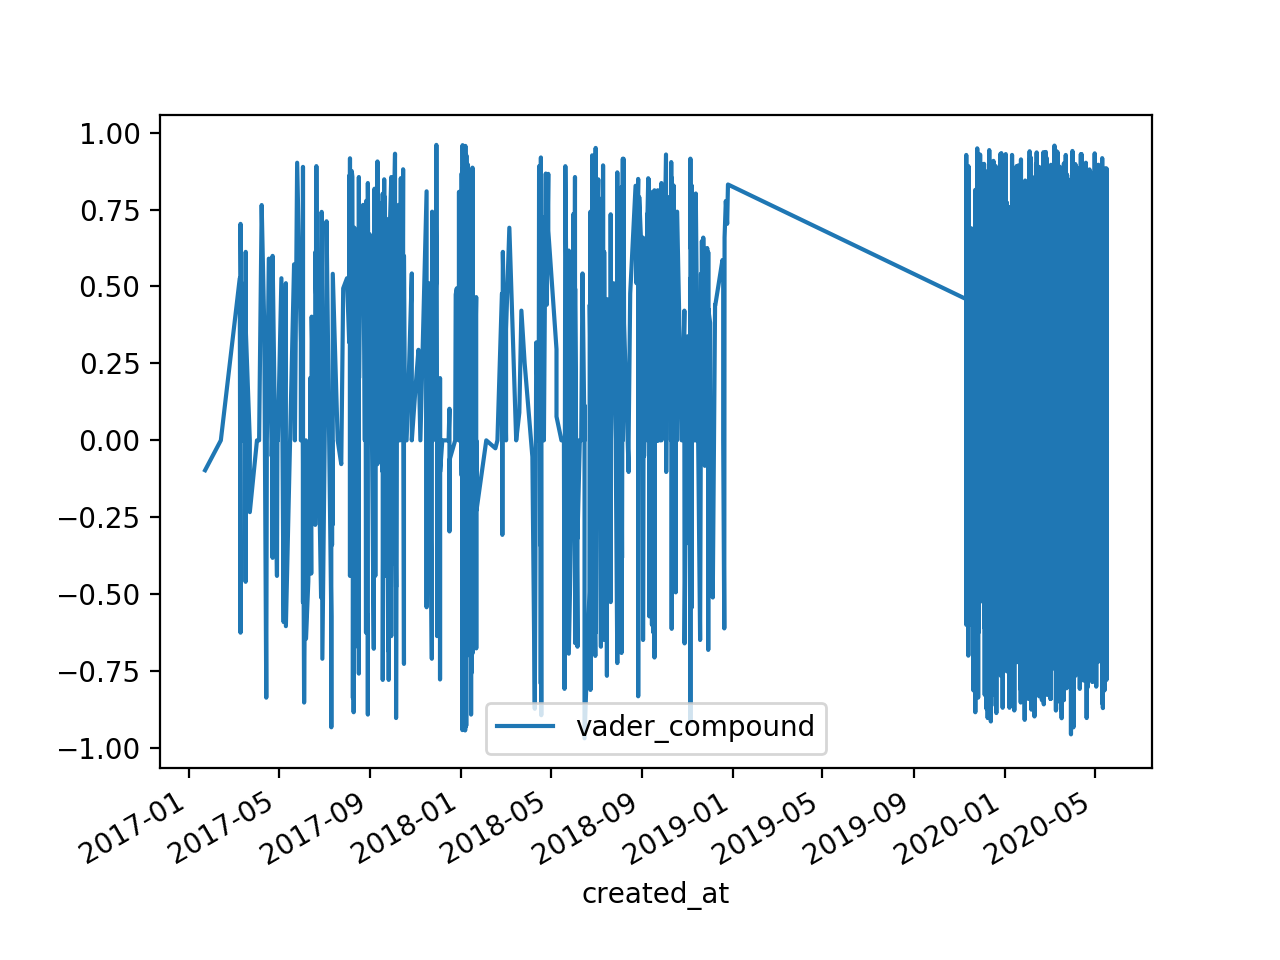

In [897]:
retweets.plot(x='created_at', y ="vader_compound")